# Tripartite relational data analysis
Try to find the characteristics of relational datasets that consist of the tripartite network from two published papers.

In [184]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import community as community_louvain
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from adjustText import adjust_text
from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from scipy.sparse.csgraph import laplacian as sparse_laplacian
from scipy.sparse.linalg import eigs
import seaborn as sns

## MAHN datasets

In [2]:
# Load the data
dme_df = pd.read_excel('MAHN/association_DME.xlsx')
dmi_df = pd.read_excel('MAHN/association_DMI.xlsx')
mime_df = pd.read_excel('MAHN/association_MIME.xlsx')

In [3]:
print(f"Unique edges in DME: {len(dme_df[['Disease', 'Metabolite']].drop_duplicates())}")
print(f"Unique edges in DMI: {len(dmi_df[['Disease', 'Microbe']].drop_duplicates())}")
print(f"Unique edges in MIME: {len(mime_df[['Microbe', 'Metabolite']].drop_duplicates())}")

Unique edges in DME: 10604
Unique edges in DMI: 13552
Unique edges in MIME: 74228


In [4]:
common_microbes = set(dmi_df["Microbe"]) | set(mime_df["Microbe"])

print(f"Common microbes in D-MI: {(len(common_microbes)/len(dmi_df['Microbe'].unique()))*100}%")
print(f"Common microbes in MI-ME: {(len(common_microbes)/len(mime_df['Microbe'].unique()))*100}%")

Common microbes in D-MI: 100.0%
Common microbes in MI-ME: 100.0%


In [5]:
common_metabolites = set(dme_df["Metabolite"]) | set(mime_df["Metabolite"])

print(f"Common metabolites in D-ME: {(len(common_metabolites)/len(dme_df['Metabolite'].unique()))*100}%")
print(f"Common metabolites in MI-ME: {(len(common_metabolites)/len(mime_df['Metabolite'].unique()))*100}%")

Common metabolites in D-ME: 100.0%
Common metabolites in MI-ME: 100.0%


In [6]:
common_diseases = set(dme_df["Disease"]) | set(dmi_df["Disease"])

print(f"Common diseases in D-ME: {(len(common_diseases) / len(dme_df['Disease'].unique())) * 100}%")
print(f"Common diseases in D-MI: {(len(common_diseases) / len(dmi_df['Disease'].unique())) * 100}%")

Common diseases in D-ME: 100.0%
Common diseases in D-MI: 100.0%


In [7]:
G = nx.Graph()

microbe_offset = len(dme_df["Disease"].unique())
metabolite_offset = len(dme_df["Disease"].unique()) + len(dmi_df["Microbe"].unique())

# add edges from the DME file (10604)
for _, row in dme_df.iterrows():
    G.add_edge(int(row['Disease']), int(row['Metabolite']) + metabolite_offset, type='DME')

# add edges from the DMI file (13552)
for _, row in dmi_df.iterrows():
    G.add_edge(int(row['Disease']), int(row['Microbe']) + microbe_offset, type='DMI')

# add edges from the MIME file (74228)
for _, row in mime_df.iterrows():
    G.add_edge(int(row['Microbe']) + microbe_offset, int(row['Metabolite']) + metabolite_offset, type='MIME')

In [9]:
# tag node types
for node in G.nodes():
    if node in dme_df['Disease'].values or node in dmi_df['Disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in dmi_df['Microbe'].values or node in mime_df['Microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in dme_df['Metabolite'].values or node in mime_df['Metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [10]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 593
Total edges: 98384


In [11]:
degree_centrality = nx.degree_centrality(G)

In [12]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 56.05% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.2748068535275868


In [13]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [14]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 593,
 'mean': np.float64(331.8178752107926),
 'std': np.float64(69.30963264905772),
 'min': np.int64(285),
 '25%': np.float64(285.0),
 '50% (median)': np.float64(285.0),
 '75%': np.float64(352.0),
 'max': np.int64(549)}

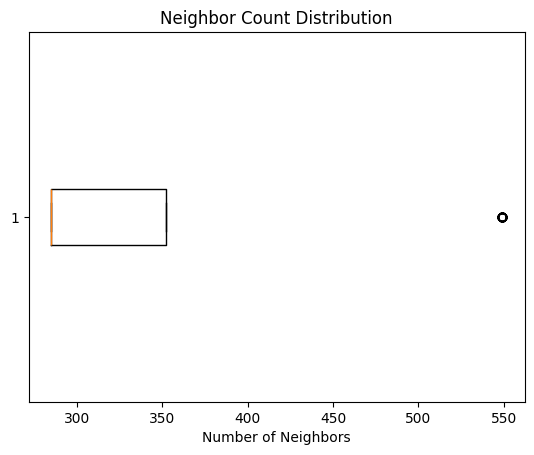

In [15]:
# box plot of neighbor counts
plt.boxplot(neighbor_counts.values(), vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

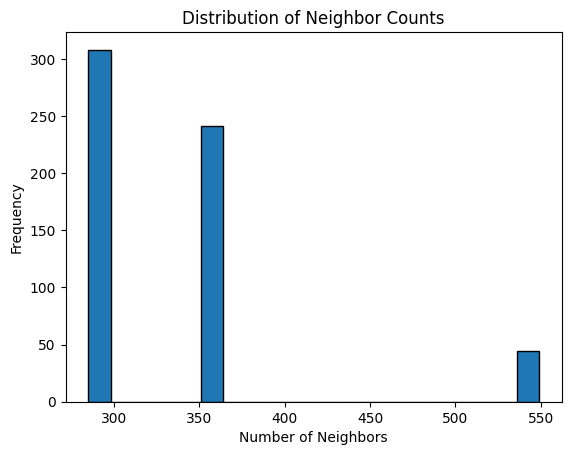

In [16]:
# histogram of neighbor counts
plt.hist(neighbor_counts.values(), bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [16]:
microbe_offset = len(dme_df["Disease"].unique())
metabolite_offset = len(dme_df["Disease"].unique()) + len(dmi_df["Microbe"].unique())

nodes = []
for disease in set(sorted(dme_df["Disease"])) | set(sorted(dmi_df["Disease"])):
    nodes.append([int(disease), "disease", "red"])
for microbe in set(sorted(dmi_df["Microbe"])) | set(sorted(mime_df["Microbe"])):
    nodes.append([int(microbe) + microbe_offset, "microbe", "blue"])
for metabolite in set(sorted(dme_df["Metabolite"])) | set(sorted(mime_df["Metabolite"])):
    nodes.append([int(metabolite) + metabolite_offset, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("MAHN_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[int(disease), int(metabolite) + metabolite_offset, value]
     for disease, metabolite, value in dme_df[["Disease", "Metabolite", "Value"]].values]
)
edges.extend(
    [[int(disease), int(microbe) + microbe_offset, value]
     for disease, microbe, value in dmi_df[["Disease", "Microbe", "Value"]].values]
)
edges.extend(
    [[int(microbe) +microbe_offset, int(metabolite) + metabolite_offset, value]
     for microbe, metabolite, value in mime_df[["Microbe", "Metabolite", "Value"]].values]
)
edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("MAHN_edges_with_labels.csv", index=False)

### Summary of MAHN datasets
- The MAHN datasets consist of three relational datasets: Disease-Metabolite (DME), Disease-Microbe (DMI), and Microbe-Metabolite (MIME).
- The DME dataset has 10604 unique edges, the DMI dataset has 13552 unique edges, and the MIME dataset has 74228 unique edges. Total edges are 98384.
- Total node count is 593 with 44 unique diseases, 308 unique microbes, and 241 unique metabolites.
- Common microbes are 100% in both files, common diseases are 100% in both files, and common metabolites are 100% in both files.
- The relational datasets from MAHN has 1 connected large component.
- Average neighbor count is ~331, median count is 285.

***

## MAGNN LastFM datasets

In [195]:
u_a = pd.read_csv("MAGNN_user_artist/user_artist.dat", sep="\t", encoding="utf-8", header=None, names=["user", "artist", "weight"])
u_u = pd.read_csv("MAGNN_user_artist/user_user(original).dat", sep="\t", encoding="utf-8", header=None, names=["user1", "user2"])
a_t = pd.read_csv("MAGNN_user_artist/artist_tag.dat", sep="\t", encoding="utf-8", header=None, names=["artist", "tag"])

In [18]:
print(f"Unique edges in u_a: {len(u_a[['user', 'artist']].drop_duplicates())}")
print(f"Unique edges in u_u: {len(u_u[['user1', 'user2']].drop_duplicates())}")
print(f"Unique edges in a_t: {len(a_t[['artist', 'tag']].drop_duplicates())}")

Unique edges in u_a: 92834
Unique edges in u_u: 25434
Unique edges in a_t: 108437


In [19]:
user = len(u_a["user"].unique())
artist = len(u_a["artist"].unique())
print(f"Number of users: {user}")
print(f"Number of artists: {artist}")

Number of users: 1892
Number of artists: 17632


In [20]:
u1 = len(u_u["user1"].unique())
u2 = len(u_u["user2"].unique())
print(f"Number of user1: {u1}")
print(f"Number of user2: {u2}")

Number of user1: 1892
Number of user2: 1892


In [21]:
artist = len(a_t["artist"].unique())
tag = len(a_t["tag"].unique())
print(f"Number of artists: {artist}")
print(f"Number of tags: {tag}")

Number of artists: 12133
Number of tags: 9718


In [22]:
common_users = set(u_a["user"]) & set(u_u["user1"]) & set(u_u["user2"])

print(f"Common users in U-A: {(len(common_users)/len(u_a['user'].unique()))*100}%")
print(f"Common users in U-U user1: {(len(common_users)/len(u_u['user1'].unique())*100)}%")
print(f"Common users in U-U user2: {(len(common_users)/len(u_u['user2'].unique())*100)}%")

Common users in U-A: 100.0%
Common users in U-U user1: 100.0%
Common users in U-U user2: 100.0%


In [23]:
common_artists = set(u_a["artist"]) & set(a_t["artist"])

print(f"Common artists in U-A: {(len(common_artists)/len(u_a['artist'].unique()))*100:.2f}%")
print(f"Common artists in A-T: {(len(common_artists)/len(a_t['artist'].unique())*100)}%")

Common artists in U-A: 68.81%
Common artists in A-T: 100.0%


In [24]:
G = nx.Graph()
artist_offset = len(u_a["user"].unique())
tag_offset = len(u_a["user"].unique()) + len(u_a["artist"].unique())

for _, row in u_a.iterrows():
    G.add_edge(int(row['user']), int(row['artist']) + artist_offset, type='user_artist')

for _, row in u_u.iterrows():
    G.add_edge(int(row['user1']), int(row['user2']), type='user_user')

for _, row in a_t.iterrows():
    G.add_edge(int(row['artist']) + artist_offset, int(row['tag']) + tag_offset, type='artist_tag')

In [25]:
for node in G.nodes():
    if node in u_a['user'].values or node in u_u['user1'].values or node in u_u["user2"].values:
        G.nodes[node]['type'] = 'user'
    elif node in u_a['artist'].values or node in a_t['artist'].values:
        G.nodes[node]['type'] = 'artist'
    elif node in a_t['tag'].values:
        G.nodes[node]['type'] = 'tag'

In [26]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 29242
Total edges: 213988


In [27]:
degree_centrality = nx.degree_centrality(G)

In [28]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.05% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.11872850770837678


In [29]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [30]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 29242,
 'mean': np.float64(14.635661035496888),
 'std': np.float64(45.737698015849865),
 'min': np.int64(1),
 '25%': np.float64(1.0),
 '50% (median)': np.float64(3.0),
 '75%': np.float64(11.0),
 'max': np.int64(2248)}

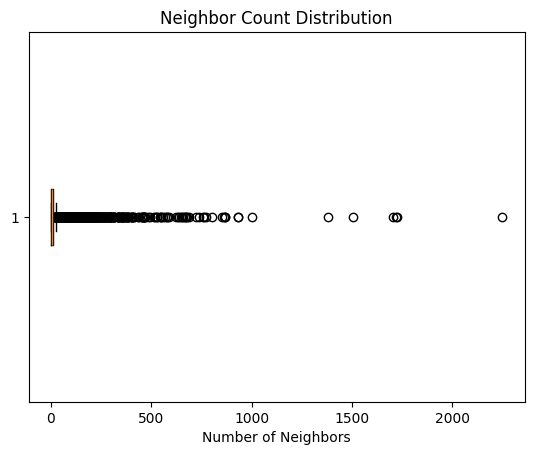

In [31]:
# box plot of neighbor counts
plt.boxplot(neighbor_counts.values(), vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

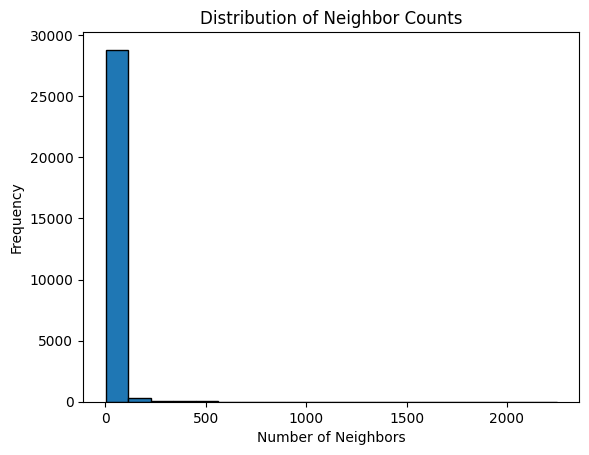

In [32]:
# histogram of neighbor counts
plt.hist(neighbor_counts.values(), bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [196]:
artist_offset = len(u_a["user"].unique())
tag_offset = len(u_a["user"].unique()) + len(u_a["artist"].unique())

nodes = []
for user in set(sorted(u_a["user"])) | set(sorted(u_u["user1"])) | set(sorted(u_u["user2"])):
    nodes.append([int(user), "user", "red"])
for artist in set(sorted(u_a["artist"])) | set(sorted(a_t["artist"])):
    nodes.append([int(artist) + artist_offset, "artist", "blue"])
for tag in set(sorted(a_t["tag"])):
    nodes.append([int(tag) + tag_offset, "tag", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("LastFM_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[int(user), int(artist) + artist_offset, value]
     for user, artist, value in u_a[["user", "artist", "weight"]].values]
)
edges.extend(
    [[int(user1), int(user2), 1]
     for user1, user2 in u_u[["user1", "user2"]].values]
)
edges.extend(
    [[int(artist) + artist_offset, int(tag) + tag_offset, 1]
     for artist, tag in a_t[["artist", "tag"]].values]
)
edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("LastFM_edges_with_labels.csv", index=False)

### Summary of MAGNN user-artist-tag datasets
- The MAGNN user-artist-tag datasets consist of three relational datasets: User-Artist (U-A), User-User (U-U), and Artist-Tag (A-T).
- The U-A dataset has 92,834 unique edges, U-U dataset has 25,434 unique edges, and the A-T dataset has 108,437 unique edges. Total edges of networkx are 213,988. However, the total edges of the dataset are 226,705, there are duplicated edges in the three datasets.
- Unique node count is 29,242 with 1892 unique users, 17632 unique artists, and 9718 unique tags.
- Common users are 100% in both files, 100% common artists in one file and 68.81% common artists in another file.
- The relational datasets from MAGNN has 1 connected large component.
- Average neighbor count is ~15, median neighbor count is 3.

***

## Full MKG datasets

### data statistics

In [2]:
disbiome_md = pd.read_csv("MKG/disbiome_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
gmmad2_mmet = pd.read_csv("MKG/gmmad2_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])
gmmad2_md = pd.read_csv("MKG/gmmad2_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
hmdb_metd = pd.read_csv("MKG/hmdb_met_disease.dat", sep="\t", encoding="utf-8", header=None, names=["metabolite", "disease"])
hmdb_mmet = pd.read_csv("MKG/hmdb_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])

In [3]:
common_microbes = set(disbiome_md["microbe"]) & set(gmmad2_mmet["microbe"]) & set(gmmad2_md["microbe"])
common_diseases = set(disbiome_md["disease"]) & set(gmmad2_md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(gmmad2_mmet["metabolite"]) & set(hmdb_metd["metabolite"]) & set(hmdb_mmet["metabolite"])

print(f"number of common microbes: {len(common_microbes)}")
print(f"number of common diseases: {len(common_diseases)}")
print(f"number of common metabolites: {len(common_metabolites)}")

number of common microbes: 60
number of common diseases: 9
number of common metabolites: 80


In [4]:
md = pd.concat([disbiome_md, gmmad2_md])
m_ct = len(md['microbe'].unique())
print(f"Number of unique microbes: {m_ct}")
print(f"Number of unique diseases: {len(md['disease'].unique())}")

Number of unique microbes: 7167
Number of unique diseases: 345


In [5]:
mmet = pd.concat([gmmad2_mmet, hmdb_mmet])
print(f"Number of unique microbes: {len(mmet['microbe'].unique())}")
print(f"Number of unique metabolites: {len(mmet['metabolite'].unique())}")

Number of unique microbes: 1308
Number of unique metabolites: 1716


In [6]:
print(f"Number of unique metabolites: {len(hmdb_metd['metabolite'].unique())}")
print(f"Number of unique diseases: {len(hmdb_metd['disease'].unique())}")

Number of unique metabolites: 22590
Number of unique diseases: 593


In [7]:
print(f"Unique edges in md: {len(md[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in mmet: {len(mmet[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in hmdb_metd: {len(hmdb_metd[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in md: 505325
Unique edges in mmet: 599176
Unique edges in hmdb_metd: 27546


In [8]:
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])

print(f"Number of common microbes: {len(common_microbes)}")
print(f"Number of common diseases: {len(common_diseases)}")
print(f"Number of common metabolites: {len(common_metabolites)}")

print(f"Common microbes in M-D: {(len(common_microbes)/len(md['microbe'].unique()))*100:.2f}%")
print(f"Common microbes in M-MET: {(len(common_microbes)/len(mmet['microbe'].unique()))*100:.2f}%")
print(f"Common diseases in M-D: {(len(common_diseases) / len(md['disease'].unique())) * 100:.2f}%")
print(f"Common diseases in HMDB_MET-D: {(len(common_diseases) / len(hmdb_metd['disease'].unique())) * 100:.2f}%")
print(f"Common metabolites in M-MET: {(len(common_metabolites)/len(mmet['metabolite'].unique()))*100:.2f}%")
print(f"Common metabolites in HMDB_MET-D: {(len(common_metabolites)/len(hmdb_metd['metabolite'].unique()))*100:.2f}%")

Number of common microbes: 273
Number of common diseases: 40
Number of common metabolites: 483
Common microbes in M-D: 3.81%
Common microbes in M-MET: 20.87%
Common diseases in M-D: 11.59%
Common diseases in HMDB_MET-D: 6.75%
Common metabolites in M-MET: 28.15%
Common metabolites in HMDB_MET-D: 2.14%


In [9]:
G = nx.Graph()

for _, row in md.iterrows():
    G.add_edge(row['microbe'], row['disease'], type='microbe_disease')
for _, row in mmet.iterrows():
    G.add_edge(row['microbe'], row['metabolite'], type='microbe_metabolite')
for _, row in hmdb_metd.iterrows():
    G.add_edge(row['metabolite'], row['disease'], type='metabolite_disease')

In [10]:
for node in G.nodes():
    if node in md['microbe'].values or node in mmet['microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in md['disease'].values or node in hmdb_metd['disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in mmet['metabolite'].values or node in hmdb_metd['metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [11]:
node_info = list(G.nodes(data=True))
node_df = pd.DataFrame(node_info, columns=["Node", "Attributes"])
node_df['type'] = node_df['Attributes'].apply(lambda x: x.get('type'))
node_type_counts = node_df['type'].value_counts()
print(node_type_counts)

type
metabolite    23823
microbe        8202
disease         898
Name: count, dtype: int64


In [12]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 32923
Total edges: 1132047


In [13]:
degree_centrality = nx.degree_centrality(G)

In [14]:
density = nx.density(G)
components = nx.number_connected_components(G)
degree_correlation = nx.degree_assortativity_coefficient(G)

print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")
print(f"Degree Correlation where high-degree nodes are connected to peripheral nodes: {degree_correlation}")

Graph Density: 0.21% of the possible connections between nodes
Number of distinct sub-networks within overall network: 27
Degree Correlation where high-degree nodes are connected to peripheral nodes: -0.38043422383946


### neighbor analysis

In [15]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [16]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 32923,
 'mean': np.float64(68.76937095647419),
 'std': np.float64(357.45719050096466),
 'min': np.int64(1),
 '25%': np.float64(1.0),
 '50% (median)': np.float64(1.0),
 '75%': np.float64(62.5),
 'max': np.int64(20017)}

In [17]:
filtered_counts = {k: v for k, v in neighbor_counts.items() if v > 100}
print(f"Number of nodes with more than 100 neighbors: {len(filtered_counts)}")

Number of nodes with more than 100 neighbors: 2036


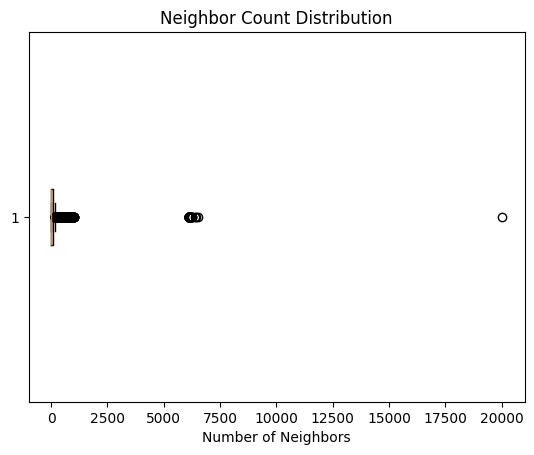

In [33]:
# box plot of neighbor counts
plt.boxplot(counts, vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

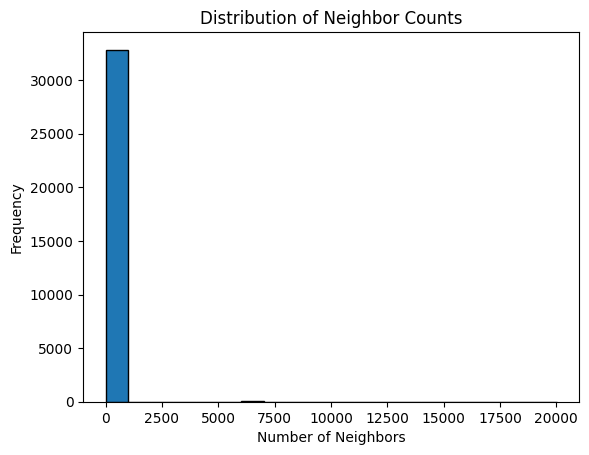

In [34]:
# histogram of neighbor counts
plt.hist(counts, bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

***

### cosmograph export

In [205]:
nodes = []
for microbe in set(sorted(md["microbe"])) | set(sorted(mmet["microbe"])):
    nodes.append([microbe, "microbe", "blue"])
for disease in set(sorted(md["disease"])) | set(sorted(hmdb_metd["disease"])):
    nodes.append([disease, "disease", "red"])
for metabolite in set(sorted(mmet["metabolite"])) | set(sorted(hmdb_metd["metabolite"])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("Full_MKG_nodes_with_colors.csv", index=False)

edges = []
edges.extend(
    [[microbe, disease, 1]
     for microbe, disease in md[["microbe", "disease"]].values]
)
edges.extend(
    [[microbe, metabolite, 1]
    for microbe, metabolite in mmet[["microbe", "metabolite"]].values]
)
edges.extend(
    [[metabolite, disease, 1]
    for metabolite, disease in hmdb_metd[["metabolite", "disease"]].values]
)

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Value"])
edges_df.to_csv("Full_MKG_edges_with_labels.csv", index=False)

***

### adjacency matrix

In [9]:
mid = md.copy()
all_microbes = pd.concat([md["microbe"], mmet["microbe"]]).unique()
all_diseases = pd.concat([md["disease"], hmdb_metd["disease"]]).unique()
all_metabolites = pd.concat([mmet["metabolite"], hmdb_metd["metabolite"]]).unique()
microbeidx = {microbe: idx for idx, microbe in enumerate(all_microbes)}
diseaseidx = {disease: idx for idx, disease in enumerate(all_diseases)}
metaboliteidx = {metabolite: idx for idx, metabolite in enumerate(all_metabolites)}

# map idx for microbe-dissease
mid["microbe"] = mid["microbe"].map(microbeidx)
mid["disease"] = mid["disease"].map(diseaseidx)

# map idx for microbe-metabolite
mime = mmet.copy()
mime["microbe"] = mime["microbe"].map(microbeidx)
mime["metabolite"] = mime["metabolite"].map(metaboliteidx)

# map idx for metabolite-disease
med = hmdb_metd.copy()
med["metabolite"] = med["metabolite"].map(metaboliteidx)
med["disease"] = med["disease"].map(diseaseidx)

In [10]:
from scipy.sparse import coo_matrix

# build adjacency matrix
# 0 for microbe, 1 for disease, 2 for metabolite
num_microbe = 8202
num_disease = 898
num_metabolite = 23823
dim = num_microbe + num_disease + num_metabolite

type_mask = np.zeros(dim, dtype=np.int16)
type_mask[num_microbe : num_microbe + num_disease] = 1
type_mask[num_microbe + num_disease :] = 2

adjM = np.zeros((dim, dim), dtype=np.int16)
for _, row in mid.iterrows():
    microID = row["microbe"]
    diseaseID = num_microbe + row["disease"]
    adjM[microID, diseaseID] = 1
    adjM[diseaseID, microID] = 1
for _, row in mime.iterrows():
    microID = row["microbe"]
    metID = num_microbe + num_disease + row["metabolite"]
    adjM[microID, metID] = 1
    adjM[metID, microID] = 1
for _, row in med.iterrows():
    metID = num_microbe + num_disease + row["metabolite"]
    diseaseID = num_microbe + row["disease"]
    adjM[metID, diseaseID] = 1
    adjM[diseaseID, metID] = 1

In [37]:
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return ax

In [ ]:
# function to downsample a large matrix
def downsample_matrix(matrix, bin_size):
    m, n = matrix.shape
    m_bins, n_bins = m // bin_size, n // bin_size
    # reshape into bins and sum within each bin
    downsampled = matrix[:m_bins * bin_size, :n_bins * bin_size].reshape(
        m_bins, bin_size, n_bins, bin_size
    ).sum(axis=(1, 3))
    return downsampled

# parameters for downsampling
bin_size = 1
downsampled_adjM = downsample_matrix(adjM, bin_size)

plt.figure(figsize=(10, 8))
plt.imshow(downsampled_adjM, cmap="binary", interpolation="nearest")
plt.colorbar(label="Connection Density (1000 nodes per bin)")
plt.xlabel("Binned Nodes (Columns)")
plt.ylabel("Binned Nodes (Rows)")
plt.show()

### Summary of entire MKG datasets
- The MKG datasets consist of three relational datasets: Microbe-Disease (MD), Microbe-Metabolite (MMET), Metabolite_Disease (HMDB_METD).
- The MD dataset has 505,325 unique edges, the MMET dataset has 599,176 unique edges, and the HMDB_METD dataset has 27,546 unique edges. Total edges are 1,132,047.
- Total node count is 32,923 with 8202 unique microbes, 898 unique diseases, and 23823 unique metabolites.
- Common microbes in M-D: 3.81%; Common microbes in M-MET: 20.87%; Common diseases in M-D: 11.59%; Common diseases in HMDB_MET-D: 6.75%; Common metabolites in M-MET: 28.15%; Common metabolites in HMDB_MET-D: 2.14%.
- The relational datasets from MKG has 27 sub-graphs.
- Average neighbor count is ~69, median neighbor count is 1.

***

## Largest connected component in the MKG network

In [46]:
largest_cc = max(nx.connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc).copy()
if "MONDO:0010543" in largest_subgraph:
    largest_subgraph.remove_node("MONDO:0010543")

In [36]:
# find the maximum clique in largest subgraph
max_clique = max(nx.find_cliques(largest_subgraph), key=len)
print(f"Maximum clique: {max_clique}")

Maximum clique: ['PUBCHEM.COMPOUND:387316', 'MONDO:0005101', 'NCBITaxon:1624']


In [37]:
density = nx.density(largest_subgraph)
print(f"Density of largest subgraph: {density}")

Density of largest subgraph: 0.0020968065159428033


In [38]:
node_info = list(largest_subgraph.nodes(data=True))
edge_info = list(largest_subgraph.edges(data=True))

In [39]:
node_df = pd.DataFrame(node_info, columns=["Node", "Attributes"])
# node_df.to_csv("MKG/largest_cc_nodes.csv", index=False)

In [40]:
node_df['type'] = node_df['Attributes'].apply(lambda x: x.get('type'))
node_type_counts = node_df['type'].value_counts()
print(node_type_counts)

type
metabolite    23789
microbe        8191
disease         880
Name: count, dtype: int64


In [41]:
edge_df = pd.DataFrame(edge_info, columns=["Source", "Target", "Attributes"])
# edge_df.to_csv("MKG/largest_cc_edges.csv", index=False)

In [42]:
edge_df['type'] = edge_df['Attributes'].apply(lambda x: x.get('type'))
edge_type_counts = edge_df['type'].value_counts()
print(edge_type_counts)

type
microbe_metabolite    599160
microbe_disease       505325
metabolite_disease     27525
Name: count, dtype: int64


In [47]:
microbes_set = set(md["microbe"]) | set(mmet["microbe"])
diseases_set = set(md["disease"]) | set(hmdb_metd["disease"])
metabolites_set = set(mmet["metabolite"]) | set(hmdb_metd["metabolite"])

nodes_list = []
for node in largest_subgraph.nodes():
    if node in microbes_set:
        nodes_list.append([node, "microbe", "blue"])
    elif node in diseases_set:
        nodes_list.append([node, "disease", "red"])
    elif node in metabolites_set:
        nodes_list.append([node, "metabolite", "green"])
    else:
        # Optional catch-all if a node doesn't appear in your data frames
        nodes_list.append([node, "unknown", "gray"])

nodes_df = pd.DataFrame(nodes_list, columns=["id", "type", "node_color"])
nodes_df.to_csv("cosmograph/MKG_largest_cc_nodes_with_colors.csv", index=False)

edges_list = []
for source, target in largest_subgraph.edges():
    edges_list.append([source, target, 1])  # or any other edge attribute

edges_df = pd.DataFrame(edges_list, columns=["Source", "Target", "Value"])
edges_df.to_csv("cosmograph/MKG_largest_cc_edges_with_labels.csv", index=False)

I think I will start with the common microbes, diseases and metabolites as input data first...

***

## MKG datasets with common nodes

### data statistics

In [3]:
disbiome_md = pd.read_csv("MKG/disbiome_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
gmmad2_mmet = pd.read_csv("MKG/gmmad2_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])
gmmad2_md = pd.read_csv("MKG/gmmad2_taxid_mondo.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "disease"])
hmdb_metd = pd.read_csv("MKG/hmdb_met_disease.dat", sep="\t", encoding="utf-8", header=None, names=["metabolite", "disease"])
hmdb_mmet = pd.read_csv("MKG/hmdb_taxid_met.dat", sep="\t", encoding="utf-8", header=None, names=["microbe", "metabolite"])

In [4]:
md = pd.concat([disbiome_md, gmmad2_md])
mmet = pd.concat([gmmad2_mmet, hmdb_mmet])

In [5]:
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])

print(f"Number of common microbes: {len(common_microbes)}")
print(f"Number of common diseases: {len(common_diseases)}")
print(f"Number of common metabolites: {len(common_metabolites)}")

Number of common microbes: 273
Number of common diseases: 40
Number of common metabolites: 483


In [6]:
# find common microbes in md and mmet
common_microbes = set(md["microbe"]) & set(mmet["microbe"])
filtered_md = md[md["microbe"].isin(common_microbes)]
filtered_mmet = mmet[mmet["microbe"].isin(common_microbes)]

missing_microbes = set(common_microbes) - set(filtered_md["microbe"])
print(f"Missing microbes: {missing_microbes}")
missing_microbes = set(common_microbes) - set(filtered_mmet["microbe"])
print(f"Missing microbes: {missing_microbes}")

# find common diseases in md and hmdb_metd
common_diseases = set(md["disease"]) & set(hmdb_metd["disease"])
filtered_md = filtered_md[filtered_md["disease"].isin(common_diseases)]
filtered_hmdb_metd = hmdb_metd[hmdb_metd["disease"].isin(common_diseases)]

missing_diseases = set(common_diseases) - set(filtered_md["disease"])
print(f"Missing diseases: {missing_diseases}")
missing_diseases = set(common_diseases) - set(filtered_hmdb_metd["disease"])
print(f"Missing diseases: {missing_diseases}")

# find common metabolites in mmet and hmdb_metd
common_metabolites = set(mmet["metabolite"]) & set(hmdb_metd["metabolite"])
filtered_mmet = filtered_mmet[filtered_mmet["metabolite"].isin(common_metabolites)]
filtered_hmdb_metd = filtered_hmdb_metd[filtered_hmdb_metd["metabolite"].isin(common_metabolites)]

missing_metabolites = set(common_metabolites) - set(filtered_mmet["metabolite"])
print(f"Missing metabolites: {missing_metabolites}")
print(f"count of missing metabolites: {len(missing_metabolites)}")
missing_metabolites = set(common_metabolites) - set(filtered_hmdb_metd["metabolite"])
print(f"Missing metabolites: {missing_metabolites}")
print(f"count of missing metabolites: {len(missing_metabolites)}")

# add weights if there are duplicate relationships
filtered_md["weight"] = filtered_md.groupby(["microbe", "disease"])["microbe"].transform("count")
filtered_mmet["weight"] = filtered_mmet.groupby(["microbe", "metabolite"])["microbe"].transform("count")
filtered_hmdb_metd["weight"] = filtered_hmdb_metd.groupby(["metabolite", "disease"])["metabolite"].transform("count")

# save as tab-separated .dat files
filtered_md.to_csv("MKG/common_microbe_disease.dat", sep="\t", index=False, header=False)
filtered_mmet.to_csv("MKG/common_microbe_metabolite.dat", sep="\t", index=False, header=False)
filtered_hmdb_metd.to_csv("MKG/common_metabolite_disease.dat", sep="\t", index=False, header=False)

Missing microbes: set()
Missing microbes: set()
Missing diseases: {'MONDO:0002974', 'MONDO:0005649', 'MONDO:0016264', 'MONDO:0001711', 'MONDO:0008315'}
Missing diseases: set()
Missing metabolites: {'CHEBI:15430', 'PUBCHEM.COMPOUND:7991', 'PUBCHEM.COMPOUND:5870', 'PUBCHEM.COMPOUND:71', 'PUBCHEM.COMPOUND:700653', 'PUBCHEM.COMPOUND:179', 'PUBCHEM.COMPOUND:6213', 'PUBCHEM.COMPOUND:8314', 'PUBCHEM.COMPOUND:439373', 'PUBCHEM.COMPOUND:176907', 'PUBCHEM.COMPOUND:445408', 'PUBCHEM.COMPOUND:83697', 'PUBCHEM.COMPOUND:1826', 'PUBCHEM.COMPOUND:5810', 'PUBCHEM.COMPOUND:3001028', 'PUBCHEM.COMPOUND:6329', 'PUBCHEM.COMPOUND:5881', 'PUBCHEM.COMPOUND:12591', 'PUBCHEM.COMPOUND:123743', 'PUBCHEM.COMPOUND:1738', 'PUBCHEM.COMPOUND:6037', 'PUBCHEM.COMPOUND:10972', 'PUBCHEM.COMPOUND:6992567', 'PUBCHEM.COMPOUND:328', 'PUBCHEM.COMPOUND:439227', 'PUBCHEM.COMPOUND:11671', 'PUBCHEM.COMPOUND:86957', 'PUBCHEM.COMPOUND:152323', 'PUBCHEM.COMPOUND:95433', 'PUBCHEM.COMPOUND:7420', 'PUBCHEM.COMPOUND:65249', 'PUBCHEM.COMPO

In [7]:
print(f"Unique edges in filtered_md: {len(filtered_md[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in filtered_mmet: {len(filtered_mmet[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in filtered_hmdb_metd: {len(filtered_hmdb_metd[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in filtered_md: 4187
Unique edges in filtered_mmet: 11170
Unique edges in filtered_hmdb_metd: 903


In [8]:
filtered_common_microbes = set(filtered_md['microbe']).intersection(set(filtered_mmet['microbe']))
filtered_common_diseases = set(filtered_md['disease']).intersection(set(filtered_hmdb_metd['disease']))
filtered_common_metabolites = set(filtered_mmet['metabolite']).intersection(set(filtered_hmdb_metd['metabolite']))

print(f"Common Microbes in filtered M-D: {len(filtered_common_microbes) / len(filtered_md['microbe'].unique()) * 100:.2f}%")
print(f"Common Microbes in filtered M-MET: {len(filtered_common_microbes) / len(filtered_mmet['microbe'].unique()) * 100:.2f}%")
print(f"Common Diseases in filtered M-D: {len(filtered_common_diseases) / len(filtered_md['disease'].unique()) * 100:.2f}%")
print(f"Common Diseases in filtered HMDB_MET-D: {len(filtered_common_diseases) / len(filtered_hmdb_metd['disease'].unique()) * 100:.2f}%")
print(f"Common Metabolites in filtered M-MET: {len(filtered_common_metabolites) / len(filtered_mmet['metabolite'].unique()) * 100:.2f}%")
print(f"Common Metabolites in filtered HMDB_MET-D: {len(filtered_common_metabolites) / len(filtered_hmdb_metd['metabolite'].unique()) * 100:.2f}%")

Common Microbes in filtered M-D: 90.11%
Common Microbes in filtered M-MET: 96.34%
Common Diseases in filtered M-D: 85.71%
Common Diseases in filtered HMDB_MET-D: 88.24%
Common Metabolites in filtered M-MET: 78.45%
Common Metabolites in filtered HMDB_MET-D: 86.86%


In [9]:
# unique microbe count
unique_microbes = len(set(filtered_md['microbe']) | set(filtered_mmet['microbe']))

# unique disease count
unique_diseases = len(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease']))

# unique metabolite count
unique_metabolites = len(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite']))

# display the counts
print(f"Unique Microbes: {unique_microbes}")
print(f"Unique Diseases: {unique_diseases}")
print(f"Unique Metabolites: {unique_metabolites}")

Unique Microbes: 272
Unique Diseases: 39
Unique Metabolites: 462


### building networtx graph

In [10]:
G = nx.Graph()

for _, index in filtered_md.iterrows():
    G.add_edge(index["microbe"], index["disease"], weight=index["weight"], type="microbe_disease")
for _, index in filtered_mmet.iterrows():
    G.add_edge(index["microbe"], index["metabolite"], weight=index["weight"], type="microbe_metabolite")
for _, index in filtered_hmdb_metd.iterrows():
    G.add_edge(index["metabolite"], index["disease"], weight=index["weight"], type="metabolite_disease")

In [11]:
for node in G.nodes():
    if node in filtered_md['microbe'].values or node in filtered_mmet['microbe'].values:
        G.nodes[node]['type'] = 'microbe'
    elif node in filtered_md['disease'].values or node in filtered_hmdb_metd['disease'].values:
        G.nodes[node]['type'] = 'disease'
    elif node in filtered_mmet['metabolite'].values or node in filtered_hmdb_metd['metabolite'].values:
        G.nodes[node]['type'] = 'metabolite'

In [12]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

Total nodes: 773
Total edges: 16260


In [13]:
degree_centrality = nx.degree_centrality(G)
density = nx.density(G)
components = nx.number_connected_components(G)

In [14]:
print(f"Graph Density: {density*100:.2f}% of the possible connections between nodes")
print(f"Number of distinct sub-networks within overall network: {components}")

Graph Density: 5.45% of the possible connections between nodes
Number of distinct sub-networks within overall network: 1


### cluster analysis

In [188]:
partition = community_louvain.best_partition(G)
modularity_score = community_louvain.modularity(partition, G)
print("Louvain Community Modularity Score:", modularity_score)

palette = sns.color_palette("Set2", 3)
disease_color, microbe_color, metabolite_color = palette[1], palette[2], palette[0]

node_colors = []
for node in G.nodes():
    if G.nodes[node]['type'] == 'microbe':
        node_colors.append(palette[2])
    elif G.nodes[node]['type'] == 'disease':
        node_colors.append(palette[1])
    elif G.nodes[node]['type'] == 'metabolite':
        node_colors.append(palette[0])

degree_centrality = nx.degree_centrality(G)
node_sizes = [50 + 50 * degree_centrality[node] for node in G.nodes()]

Louvain Community Modularity Score: 0.33903861379940275


#### Louvain Community Detection

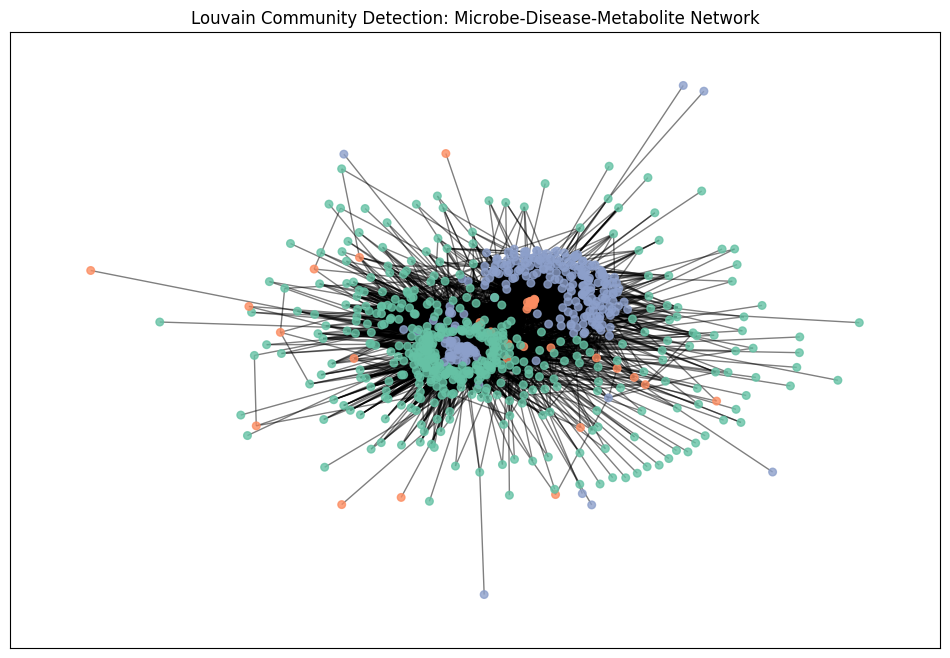

In [173]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos, font_size=2)

plt.title('Louvain Community Detection: Microbe-Disease-Metabolite Network')
plt.show()

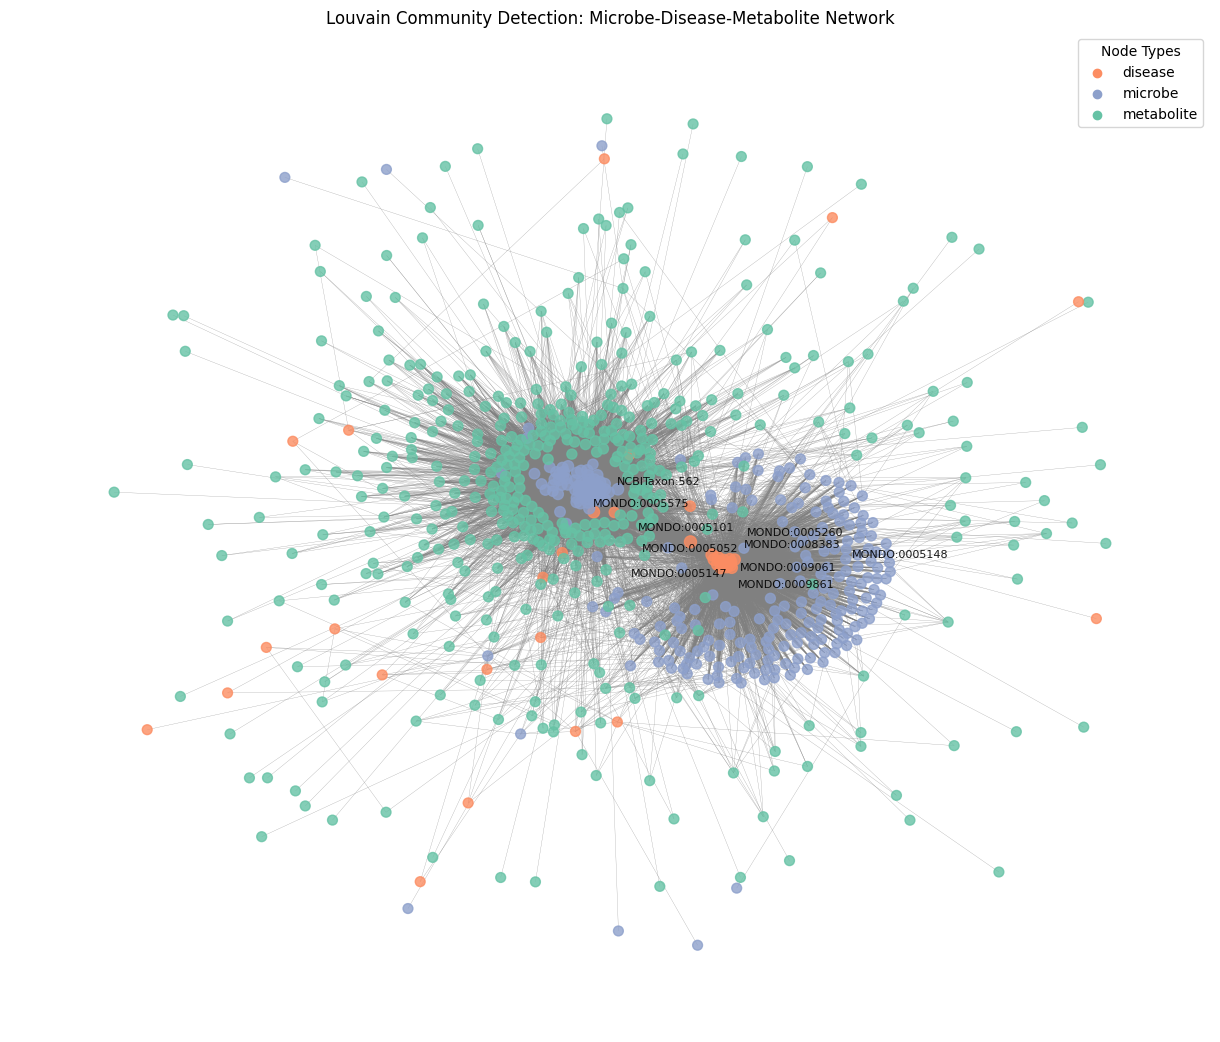

In [172]:
pos = nx.spring_layout(G, k=0.30, seed=42)  # k controls spacing

plt.figure(figsize=(12, 10))

nx.draw(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    alpha=0.8,
    edge_color="gray",
    width=[0.1 + G[u][v].get('weight', 0.1) * 0.1 for u, v in G.edges()],
    with_labels=False
)

# top 10 nodes for labels
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]
labels = {node: node for node in top_nodes}

texts = []
for node, (x, y) in pos.items():
    if node in labels:
        texts.append(plt.text(x, y, labels[node], fontsize=8, color='black', alpha=0.9))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

color_legend = {'disease': palette[1], 'microbe': palette[2], 'metabolite': palette[0]}
for label, color in color_legend.items():
    plt.scatter([], [], color=color, label=label)
plt.legend(title="Node Types")

plt.title("Louvain Community Detection: Microbe-Disease-Metabolite Network")
plt.show()

In [44]:
from collections import defaultdict

clusters = defaultdict(list)
for node, cluster in partition.items():
    clusters[cluster].append(node)

In [45]:
disease_clusters = {cluster: [node for node in nodes if G.nodes[node]['type'] == 'disease']
                    for cluster, nodes in clusters.items()}

for cluster_id, diseases in disease_clusters.items():
    print(f"Cluster {cluster_id} has the following diseases:")
    for disease in diseases:
        print(f"  - {disease}")
    print()

Cluster 0 has the following diseases:
  - MONDO:0008487
  - MESH:D012907
  - MONDO:0005101
  - MONDO:0009061
  - MONDO:0005546
  - MONDO:0005052
  - MONDO:0010726
  - MONDO:0005264
  - MONDO:0005300
  - MONDO:0008383
  - MONDO:0007803
  - MONDO:0005010
  - MONDO:0015183
  - MONDO:0011565
  - MONDO:0006665
  - MONDO:0005298
  - MONDO:0002009
  - MONDO:0011962
  - MONDO:0024388
  - MONDO:0005260
  - MONDO:0005147
  - MONDO:0009861
  - MONDO:0005154
  - MONDO:0018076
  - MONDO:0005027
  - MONDO:0011382
  - MONDO:0005148
  - MONDO:0001711
  - MONDO:0005649

Cluster 1 has the following diseases:
  - MONDO:0005575
  - MONDO:0005090
  - MONDO:0008226
  - MONDO:0008903
  - MONDO:0002635
  - MONDO:0005081
  - MONDO:0858950
  - MONDO:0002974

Cluster 2 has the following diseases:
  - MONDO:0007739
  - MONDO:0008315



In [42]:
microbes_clusters = {cluster: [node for node in nodes if G.nodes[node]['type'] == 'microbe']
                    for cluster, nodes in clusters.items()}

for cluster_id, microbes in microbes_clusters.items():
    print(f"Cluster {cluster_id} has the following microbes:")
    for microbe in microbes:
        print(f"  - {microbe}")
    print()

Cluster 0 has the following microbes:
  - NCBITaxon:1686
  - NCBITaxon:820
  - NCBITaxon:1382
  - NCBITaxon:28116
  - NCBITaxon:287
  - NCBITaxon:74426
  - NCBITaxon:871665
  - NCBITaxon:29523
  - NCBITaxon:239935
  - NCBITaxon:1736
  - NCBITaxon:216816
  - NCBITaxon:729
  - NCBITaxon:116085
  - NCBITaxon:40520
  - NCBITaxon:360807
  - NCBITaxon:821
  - NCBITaxon:573
  - NCBITaxon:1681
  - NCBITaxon:142586
  - NCBITaxon:1493
  - NCBITaxon:28141
  - NCBITaxon:1506
  - NCBITaxon:39491
  - NCBITaxon:292800
  - NCBITaxon:446660
  - NCBITaxon:33043
  - NCBITaxon:33038
  - NCBITaxon:165179
  - NCBITaxon:1352
  - NCBITaxon:1280
  - NCBITaxon:853
  - NCBITaxon:69823
  - NCBITaxon:1338
  - NCBITaxon:29347
  - NCBITaxon:29466
  - NCBITaxon:33035
  - NCBITaxon:839
  - NCBITaxon:294
  - NCBITaxon:1613
  - NCBITaxon:1488
  - NCBITaxon:1308
  - NCBITaxon:38289
  - NCBITaxon:823
  - NCBITaxon:39488
  - NCBITaxon:470
  - NCBITaxon:46506
  - NCBITaxon:1689
  - NCBITaxon:1309
  - NCBITaxon:501571
  - NC

In [43]:
metabolites_clusters = {cluster: [node for node in nodes if G.nodes[node]['type'] == 'metabolite']
                    for cluster, nodes in clusters.items()}

for cluster_id, metabolites in metabolites_clusters.items():
    print(f"Cluster {cluster_id} has the following metabolites:")
    for metabolite in metabolites:
        print(f"  - {metabolite}")
    print()

Cluster 0 has the following metabolites:
  - PUBCHEM.COMPOUND:6723
  - PUBCHEM.COMPOUND:6508
  - PUBCHEM.COMPOUND:107
  - PUBCHEM.COMPOUND:127
  - PUBCHEM.COMPOUND:222528
  - PUBCHEM.COMPOUND:802
  - PUBCHEM.COMPOUND:91469
  - PUBCHEM.COMPOUND:998
  - PUBCHEM.COMPOUND:996
  - PUBCHEM.COMPOUND:115089
  - PUBCHEM.COMPOUND:439709
  - PUBCHEM.COMPOUND:5280343
  - PUBCHEM.COMPOUND:1001
  - PUBCHEM.COMPOUND:379
  - PUBCHEM.COMPOUND:348154
  - PUBCHEM.COMPOUND:878
  - PUBCHEM.COMPOUND:9958
  - PUBCHEM.COMPOUND:1031
  - PUBCHEM.COMPOUND:89472
  - PUBCHEM.COMPOUND:10394
  - PUBCHEM.COMPOUND:780
  - PUBCHEM.COMPOUND:9378
  - PUBCHEM.COMPOUND:5280899
  - PUBCHEM.COMPOUND:3848
  - PUBCHEM.COMPOUND:10296
  - CHEBI:62064
  - PUBCHEM.COMPOUND:297
  - PUBCHEM.COMPOUND:180
  - PUBCHEM.COMPOUND:1738118
  - PUBCHEM.COMPOUND:12358756
  - PUBCHEM.COMPOUND:444173
  - PUBCHEM.COMPOUND:6560
  - PUBCHEM.COMPOUND:31260
  - PUBCHEM.COMPOUND:8468
  - PUBCHEM.COMPOUND:91
  - PUBCHEM.COMPOUND:445858
  - PUBCHEM.COM

In [175]:
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# count nodes in each community
from collections import Counter
community_counts = Counter(partition.values())
print("Community sizes:", community_counts)

Community sizes: Counter({0: 287, 1: 281, 2: 205})


In [180]:
node_data = [(node, data['type'], partition[node]) for node, data in G.nodes(data=True)]
df_partition = pd.DataFrame(node_data, columns=["Node", "Type", "Community"])
df_sorted_partition = df_partition[df_partition["Community"].isin([0, 1, 2])].sort_values(by="Community").reset_index(drop=True)
df_sorted_partition

,Node,Type,Community
0,NCBITaxon:1686,microbe,0
1,NCBITaxon:13335,microbe,0
2,NCBITaxon:920,microbe,0
3,NCBITaxon:1491,microbe,0
4,NCBITaxon:33996,microbe,0
...,...,...,...
768,PUBCHEM.COMPOUND:370,metabolite,2
769,PUBCHEM.COMPOUND:43,metabolite,2
770,PUBCHEM.COMPOUND:93078,metabolite,2
771,PUBCHEM.COMPOUND:439246,metabolite,2


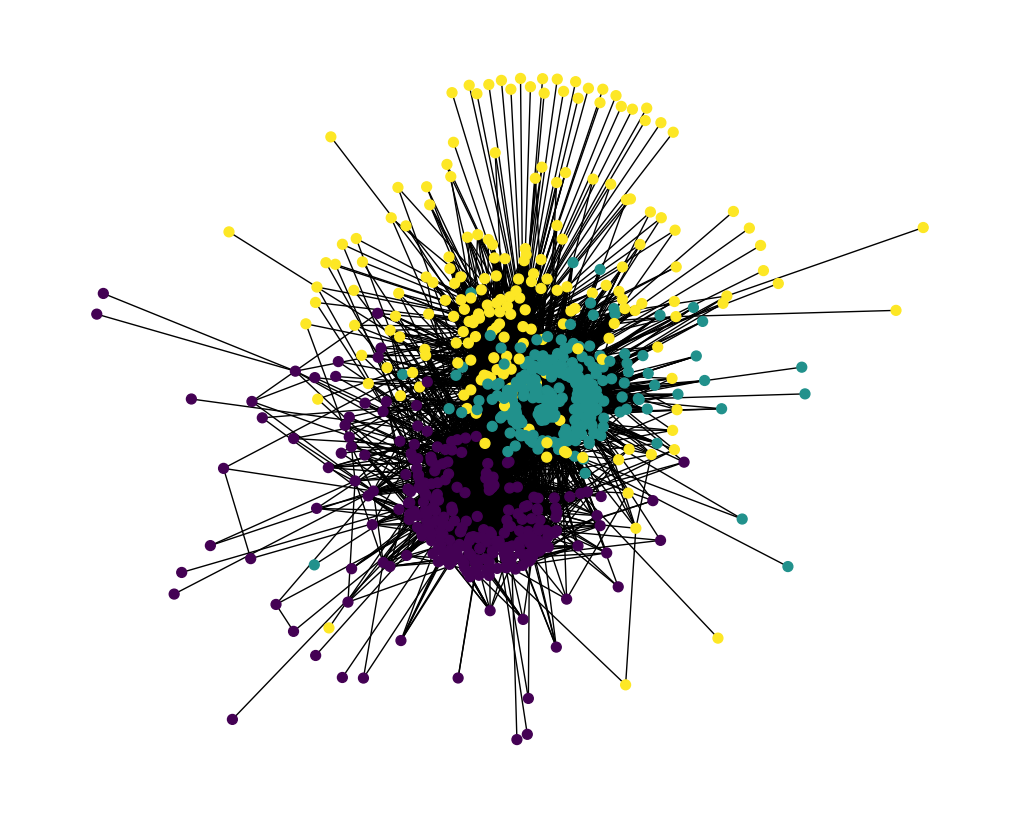

In [176]:
colors = [partition[node] for node in G.nodes()]
plt.figure(figsize=(10, 8))
nx.draw(G, node_color=colors, with_labels=False, node_size=50, cmap='viridis')
plt.show()

In [177]:
microbes = [node for node, data in G.nodes(data=True) if data['type'] == 'microbe']
diseases = [node for node, data in G.nodes(data=True) if data['type'] == 'disease']
metabolites = [node for node, data in G.nodes(data=True) if data['type'] == 'metabolite']

# count nodes per community
community_microbe_counts = Counter(partition[node] for node in microbes)
community_disease_counts = Counter(partition[node] for node in diseases)
community_metabolite_counts = Counter(partition[node] for node in metabolites)

print("Microbes per community:", community_microbe_counts)
print("Diseases per community:", community_disease_counts)
print("Metabolites per community:", community_metabolite_counts)

Microbes per community: Counter({0: 202, 1: 53, 2: 17})
Diseases per community: Counter({0: 29, 2: 8, 1: 2})
Metabolites per community: Counter({1: 226, 2: 180, 0: 56})


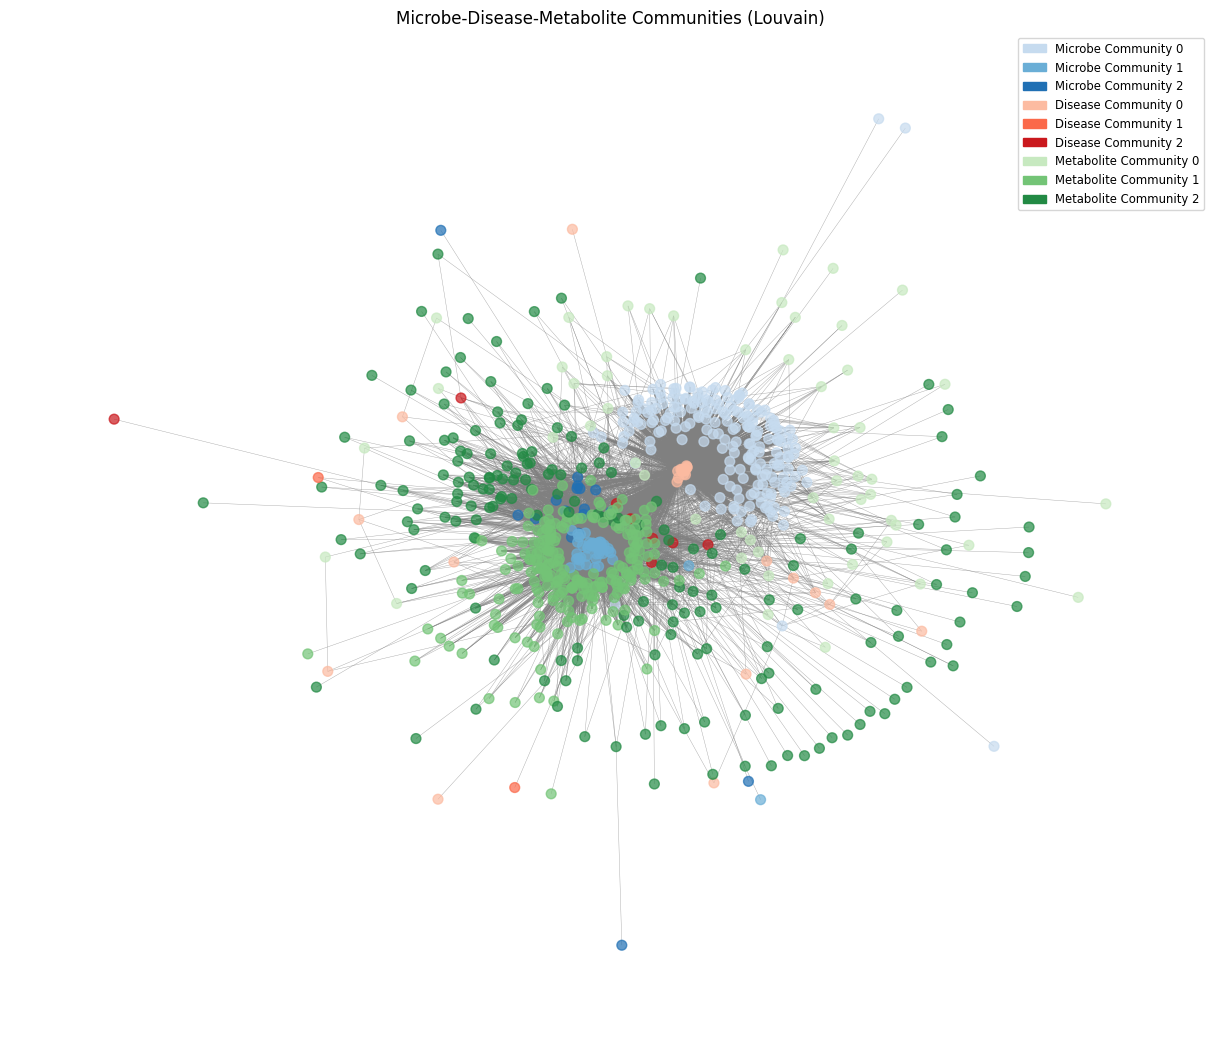

In [187]:
# classify nodes by type
microbes = [node for node, data in G.nodes(data=True) if data['type'] == 'microbe']
diseases = [node for node, data in G.nodes(data=True) if data['type'] == 'disease']
metabolites = [node for node, data in G.nodes(data=True) if data['type'] == 'metabolite']

community_microbe_counts = Counter(partition[node] for node in microbes)
community_disease_counts = Counter(partition[node] for node in diseases)
community_metabolite_counts = Counter(partition[node] for node in metabolites)

palette_blue = sns.color_palette("Blues", 3)
palette_red = sns.color_palette("Reds", 3)
palette_green = sns.color_palette("Greens", 3)

color_map = {}
for node in G.nodes():
    community = partition[node]
    if node in microbes:
        color_map[node] = palette_blue[community % 3]
    elif node in diseases:
        color_map[node] = palette_red[community % 3]
    elif node in metabolites:
        color_map[node] = palette_green[community % 3]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    node_color=[color_map[node] for node in G.nodes()],
    with_labels=False,
    node_size=50,
    edge_color="gray",
    width = 0.3,
    alpha=0.7
)

# type_legend = [
#     mpatches.Patch(color='blue', label='Microbe'),
#     mpatches.Patch(color='red', label='Disease'),
#     mpatches.Patch(color='green', label='Metabolite')
# ]
community_legend = [
    mpatches.Patch(color=palette_blue[0], label='Microbe Community 0'),
    mpatches.Patch(color=palette_blue[1], label='Microbe Community 1'),
    mpatches.Patch(color=palette_blue[2], label='Microbe Community 2'),
    mpatches.Patch(color=palette_red[0], label='Disease Community 0'),
    mpatches.Patch(color=palette_red[1], label='Disease Community 1'),
    mpatches.Patch(color=palette_red[2], label='Disease Community 2'),
    mpatches.Patch(color=palette_green[0], label='Metabolite Community 0'),
    mpatches.Patch(color=palette_green[1], label='Metabolite Community 1'),
    mpatches.Patch(color=palette_green[2], label='Metabolite Community 2')
]

plt.legend(handles=community_legend, loc='best', fontsize='small', frameon=True)
plt.title("Microbe-Disease-Metabolite Communities (Louvain)")
plt.show()

#### K-Means Cluster

#### UMAP

In [75]:
adjM = nx.adjacency_matrix(G).todense()
node_labels = list(G.nodes())
adj_df = pd.DataFrame(adjM, index=node_labels, columns=node_labels)

In [76]:
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(adj_df)
umap_result

/Users/bailinzhang/Documents/Wu_Lab/Projects/Network_Analysis/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/bailinzhang/Documents/Wu_Lab/Projects/Network_Analysis/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[-36.46826  ,  53.89875  ],
       [ 22.388395 ,   1.6227915],
       [-36.54201  ,  53.686222 ],
       ...,
       [-13.626535 ,  21.239578 ],
       [-13.52093  ,  21.193485 ],
       [-13.689094 ,  21.143812 ]], dtype=float32)

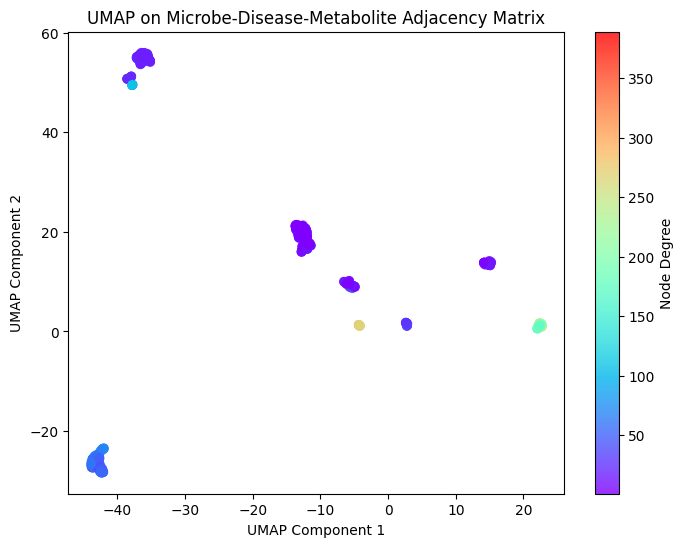

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=[G.degree[node] for node in G.nodes()], cmap='rainbow', alpha=0.8)
plt.colorbar(label='Node Degree')
plt.title("UMAP on Microbe-Disease-Metabolite Adjacency Matrix")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [72]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
umap_df = pd.DataFrame(umap_result, columns=['umap_x', 'umap_y'])
umap_df['node'] = node_labels
umap_df['cluster'] = kmeans.fit_predict(umap_result)

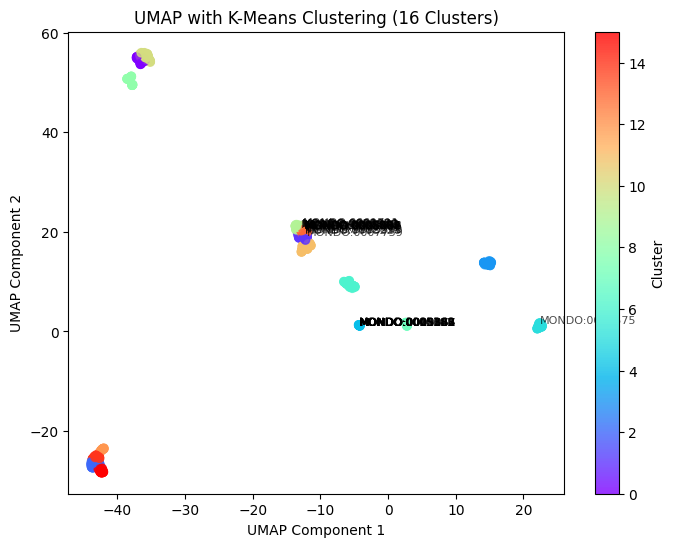

In [64]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_df['umap_x'], umap_df['umap_y'], c=umap_df['cluster'], cmap='rainbow', alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.title(f"UMAP with K-Means Clustering ({n_clusters} Clusters)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

for i, node in enumerate(umap_df['node']):
    if G.nodes[node]['type'] == 'disease':
        plt.annotate(node, (umap_df.loc[i, 'umap_x'], umap_df.loc[i, 'umap_y']), fontsize=8, alpha=0.7)

plt.show()

In [69]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
umap_df = pd.DataFrame(umap_result, columns=['umap_x', 'umap_y'])
umap_df['node'] = node_labels
umap_df['cluster'] = kmeans.fit_predict(umap_result)

umap_df['type'] = [G.nodes[node]['type'] for node in umap_df['node']]

disease_nodes_df = umap_df[umap_df['type'] == 'disease']
print("\nDisease Nodes with Cluster Info:")
disease_nodes_df[['node', 'cluster', 'umap_x', 'umap_y']]


Disease Nodes with Cluster Info:


,node,cluster,umap_x,umap_y
1,MONDO:0005575,5,22.388395,1.622792
3,MONDO:0008487,9,-12.275105,20.558161
5,MESH:D012907,9,-12.366328,20.638422
7,MONDO:0005101,4,-4.237936,1.225912
9,MONDO:0009061,4,-4.184895,1.172693
10,MONDO:0005546,9,-12.189897,20.622274
12,MONDO:0005052,4,-4.308327,1.292514
16,MONDO:0010726,4,-4.249125,1.228785
17,MONDO:0005090,9,-12.450883,20.770205
20,MONDO:0008226,1,-12.220785,19.714668


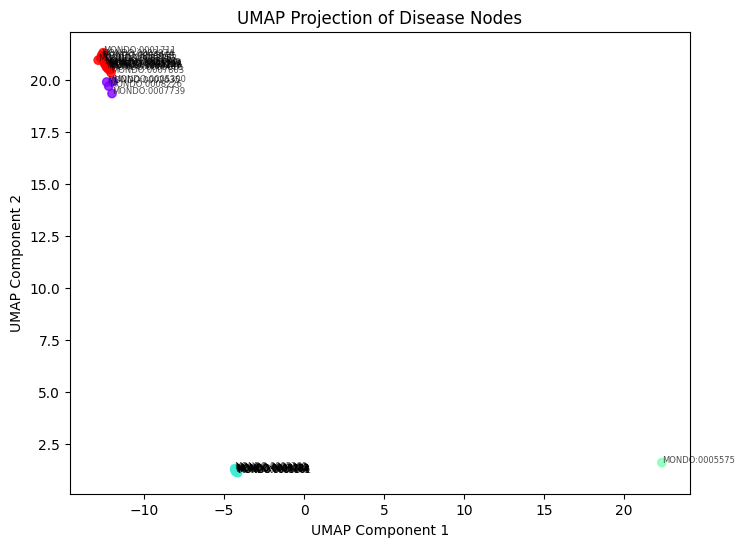

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(disease_nodes_df['umap_x'], disease_nodes_df['umap_y'],
            c=disease_nodes_df['cluster'], cmap='rainbow', alpha=0.8)

plt.title("UMAP Projection of Disease Nodes")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

for i, row in disease_nodes_df.iterrows():
    plt.annotate(row['node'], (row['umap_x'], row['umap_y']), fontsize=6, alpha=0.7)

plt.show()

#### PCoA analysis

##### Euclidean Distance

In [130]:
# Euclidean distance for direct neighbor analysis
distance_matrix = pairwise_distances(adjM, metric='euclidean')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_result = mds.fit_transform(distance_matrix)

In [131]:
pcoa_df = pd.DataFrame(pcoa_result, columns=['PCoA1', 'PCoA2'])
pcoa_df['node'] = node_labels
pcoa_df['type'] = [G.nodes[node]['type'] for node in pcoa_df['node']]
pcoa_df.head()

,PCoA1,PCoA2,node,type
0,3.907013,-1.051337,NCBITaxon:1686,microbe
1,1.298209,17.127647,MONDO:0005575,disease
2,4.296534,-2.184928,NCBITaxon:820,microbe
3,0.614798,-3.866562,MONDO:0008487,disease
4,2.649492,-0.145818,NCBITaxon:1382,microbe


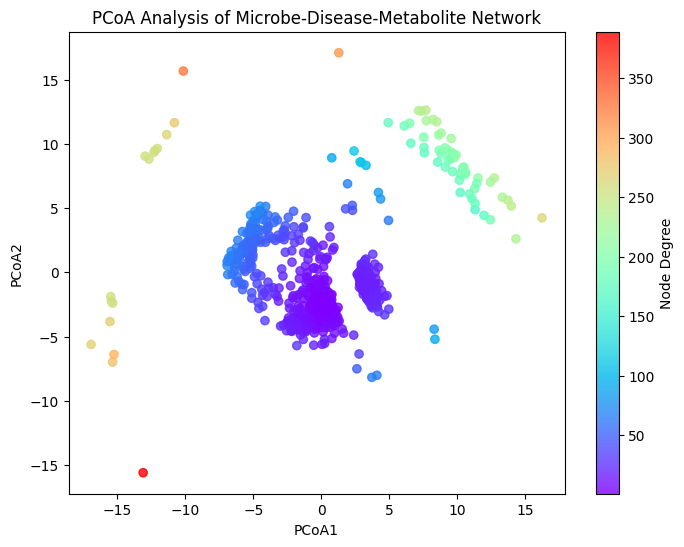

In [140]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pcoa_df['PCoA1'], pcoa_df['PCoA2'],
                      c=[G.degree[node] for node in node_labels], cmap='rainbow', alpha=0.8)

plt.colorbar(scatter, label='Node Degree')
plt.title("PCoA Analysis of Microbe-Disease-Metabolite Network")
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")

# for i, row in pcoa_df.iterrows():
#     if G.nodes[row['node']]['type'] == 'disease':
#         plt.annotate(row['node'], (row['PCoA1'], row['PCoA2']), fontsize=6, alpha=0.7)

plt.show()

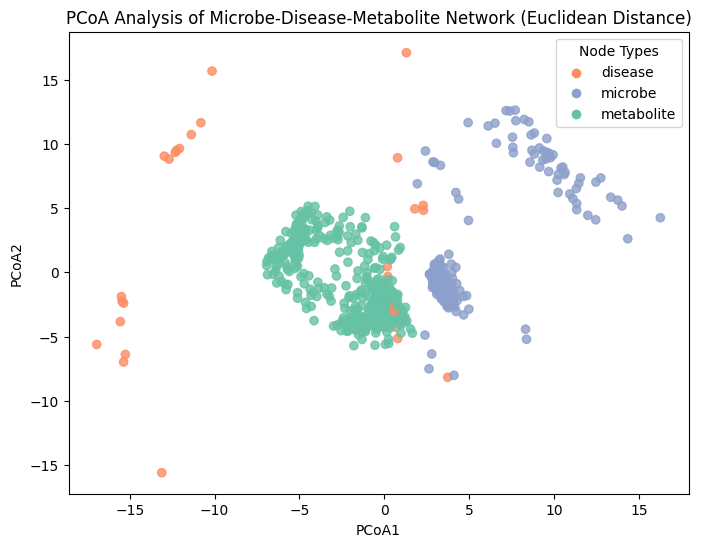

In [142]:
palette = sns.color_palette("Set2")
disease_color, microbe_color, metabolite_color = palette[1], palette[2], palette[0]

node_colors = [
    disease_color if G.nodes[node]['type'] == 'disease' else
    microbe_color if G.nodes[node]['type'] == 'microbe' else
    metabolite_color for node in pcoa_df['node']
]

plt.figure(figsize=(8, 6))
plt.scatter(pcoa_df['PCoA1'], pcoa_df['PCoA2'], c=node_colors, alpha=0.8)

color_legend = {'disease': palette[1], 'microbe': palette[2], 'metabolite': palette[0]}
for label, color in color_legend.items():
    plt.scatter([], [], color=color, label=label)
plt.legend(title="Node Types")

plt.title("PCoA Analysis of Microbe-Disease-Metabolite Network (Euclidean Distance)")
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")

# for i, row in pcoa_df.iterrows():
#     if G.nodes[row['node']]['type'] == 'disease':
#         plt.annotate(row['node'], (row['PCoA1'], row['PCoA2']), fontsize=5, alpha=0.5)

plt.show()

##### Euclidean Distance (Diseases - Metabolites)

In [98]:
diseases_df = pcoa_df[pcoa_df['type'] == 'disease'].reset_index(drop=True)
metabolites_df = pcoa_df[pcoa_df['type'] == 'metabolite'].reset_index(drop=True)

distances = cdist(diseases_df[['PCoA1', 'PCoA2']], metabolites_df[['PCoA1', 'PCoA2']], metric='euclidean')

nearest_metabolites_idx = distances.argmin(axis=1)
nearest_metabolites = metabolites_df.iloc[nearest_metabolites_idx].reset_index(drop=True)

disease_metabolite_info = pd.DataFrame({
    'disease_node': diseases_df['node'],
    'disease_pcoa1': diseases_df['PCoA1'],
    'disease_pcoa2': diseases_df['PCoA2'],
    'nearest_metabolite': nearest_metabolites['node'],
    'metabolite_pcoa1': nearest_metabolites['PCoA1'],
    'metabolite_pcoa2': nearest_metabolites['PCoA2'],
    'distance': distances.min(axis=1)  # distance between disease and nearest metabolite
})

# show the closest pairs of diseases and metabolites
disease_metabolite_info.sort_values(by='distance').head(5)

,disease_node,disease_pcoa1,disease_pcoa2,nearest_metabolite,metabolite_pcoa1,metabolite_pcoa2,distance
22,MONDO:0007739,-0.010421,-1.959264,PUBCHEM.COMPOUND:150929,-0.010421,-1.959264,1.421557e-14
11,MONDO:0005264,0.506875,-3.090547,CHEBI:29073,0.482142,-3.045215,5.163952e-02
2,MESH:D012907,0.695086,-3.656897,PUBCHEM.COMPOUND:115089,0.645271,-3.677350,5.385030e-02
37,MONDO:0002974,0.312082,-2.213987,PUBCHEM.COMPOUND:8617,0.303832,-2.267426,5.407176e-02
21,MONDO:0005298,0.412222,-2.712640,PUBCHEM.COMPOUND:335,0.392985,-2.653227,6.244993e-02


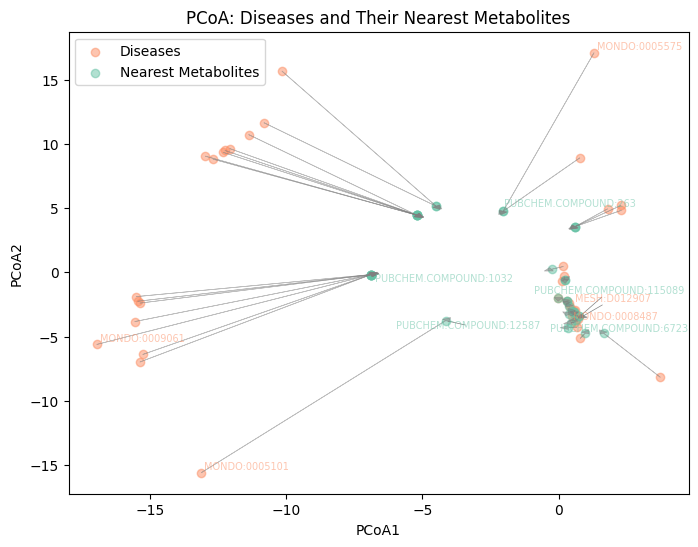

In [139]:
plt.figure(figsize=(8, 6))

plt.scatter(disease_metabolite_info['disease_pcoa1'], disease_metabolite_info['disease_pcoa2'],
            color=palette[1], label='Diseases', alpha=0.5)

plt.scatter(disease_metabolite_info['metabolite_pcoa1'], disease_metabolite_info['metabolite_pcoa2'],
            color=palette[0], label='Nearest Metabolites', alpha=0.5)

for i in range(len(disease_metabolite_info)):
    plt.arrow(
        disease_metabolite_info.loc[i, 'disease_pcoa1'], disease_metabolite_info.loc[i, 'disease_pcoa2'],
        disease_metabolite_info.loc[i, 'metabolite_pcoa1'] - disease_metabolite_info.loc[i, 'disease_pcoa1'],
        disease_metabolite_info.loc[i, 'metabolite_pcoa2'] - disease_metabolite_info.loc[i, 'disease_pcoa2'],
        color="gray", alpha=0.5, head_width=0.3, head_length=0.3, linewidth=0.5
    )

texts = []
for i, row in disease_metabolite_info.head(5).iterrows():
    texts.append(plt.text(row['disease_pcoa1'], row['disease_pcoa2'], row['disease_node'],
                          fontsize=7, color=palette[1], alpha=0.5))
    texts.append(plt.text(row['metabolite_pcoa1'], row['metabolite_pcoa2'], row['nearest_metabolite'],
                          fontsize=7, color=palette[0], alpha=0.5))

# adjust overlapping annotations
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.xlabel('PCoA1')
plt.ylabel('PCoA2')
plt.title('PCoA: Diseases and Their Nearest Metabolites')
plt.legend()

plt.show()

##### Laplacian Distance (Communte-time)

In [144]:
# laplacian distance
laplacian = nx.laplacian_matrix(G).todense()
laplacian_pinv = pinv(laplacian)

# calculate commute-time distance
n = laplacian_pinv.shape[0]
distances = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        distances[i, j] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - 2 * laplacian_pinv[i, j]

In [145]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_result = mds.fit_transform(distances)

In [146]:
pcoa_df = pd.DataFrame(pcoa_result, columns=['PCoA1', 'PCoA2'])
pcoa_df['node'] = list(G.nodes())
pcoa_df['type'] = [G.nodes[node]['type'] for node in pcoa_df['node']]
pcoa_df.head()

,PCoA1,PCoA2,node,type
0,-0.009827,0.050897,NCBITaxon:1686,microbe
1,0.000398,-0.000998,MONDO:0005575,disease
2,-0.028033,-0.030369,NCBITaxon:820,microbe
3,-0.198586,0.133254,MONDO:0008487,disease
4,0.021157,0.055511,NCBITaxon:1382,microbe


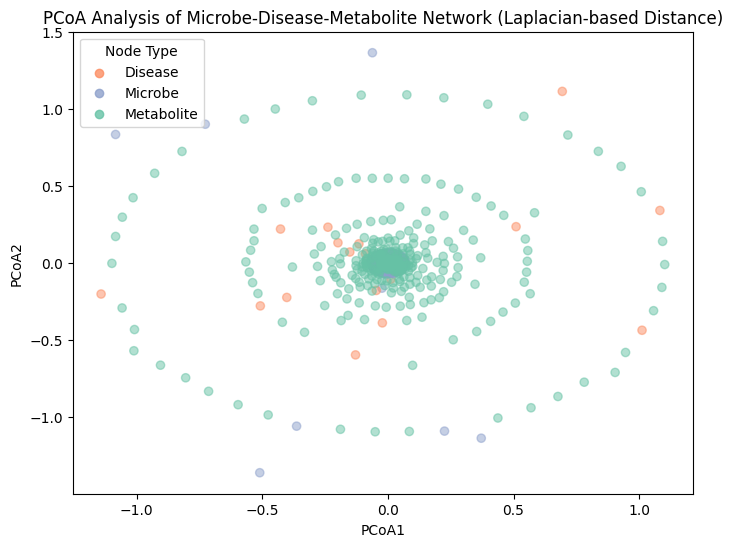

In [147]:
plt.figure(figsize=(8, 6))

palette = sns.color_palette("Set2")
disease_color, microbe_color, metabolite_color = palette[1], palette[2], palette[0]

node_colors = [
    disease_color if G.nodes[node]['type'] == 'disease' else
    microbe_color if G.nodes[node]['type'] == 'microbe' else
    metabolite_color for node in pcoa_df['node']
]

plt.scatter(pcoa_df['PCoA1'], pcoa_df['PCoA2'], c=node_colors, alpha=0.5)
plt.scatter([], [], color=disease_color, alpha=0.8, label='Disease')
plt.scatter([], [], color=microbe_color, alpha=0.8, label='Microbe')
plt.scatter([], [], color=metabolite_color, alpha=0.8, label='Metabolite')
plt.legend(title='Node Type')
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.title("PCoA Analysis of Microbe-Disease-Metabolite Network (Laplacian-based Distance)")
plt.show()

##### Random Walk-based Distance

In [199]:
# random walk-based distance
rw_laplacian = sparse_laplacian(nx.adjacency_matrix(G), normed=True)
# k = min(10, G.number_of_nodes() - 1)
# eigenvalues, eigenvectors = eigs(rw_laplacian, k=k, which='SM')

rw_laplacian_dense = rw_laplacian.toarray()
# calculate eigenvalues and eigenvectors of the Laplacian
eigenvalues, eigenvectors = eigs(rw_laplacian_dense)

In [200]:
# diffusion distance
diffusion_map = np.real(eigenvectors)
diffusion_distances = pairwise_distances(diffusion_map, metric='euclidean')

In [201]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_result = mds.fit_transform(diffusion_distances)

In [202]:
pcoa_df = pd.DataFrame(pcoa_result, columns=['PCoA1', 'PCoA2'])
pcoa_df['node'] = list(G.nodes())
pcoa_df['type'] = [G.nodes[node]['type'] for node in pcoa_df['node']]
pcoa_df

,PCoA1,PCoA2,node,type
0,0.015359,-0.032895,NCBITaxon:1686,microbe
1,0.032557,-0.296678,MONDO:0005575,disease
2,0.038027,-0.033180,NCBITaxon:820,microbe
3,0.093132,0.059003,MONDO:0008487,disease
4,0.036518,-0.025575,NCBITaxon:1382,microbe
...,...,...,...,...
768,-0.011273,0.063045,PUBCHEM.COMPOUND:6037,metabolite
769,0.014279,0.015210,PUBCHEM.COMPOUND:445408,metabolite
770,0.014279,0.015210,PUBCHEM.COMPOUND:328,metabolite
771,0.014279,0.015210,PUBCHEM.COMPOUND:5699,metabolite


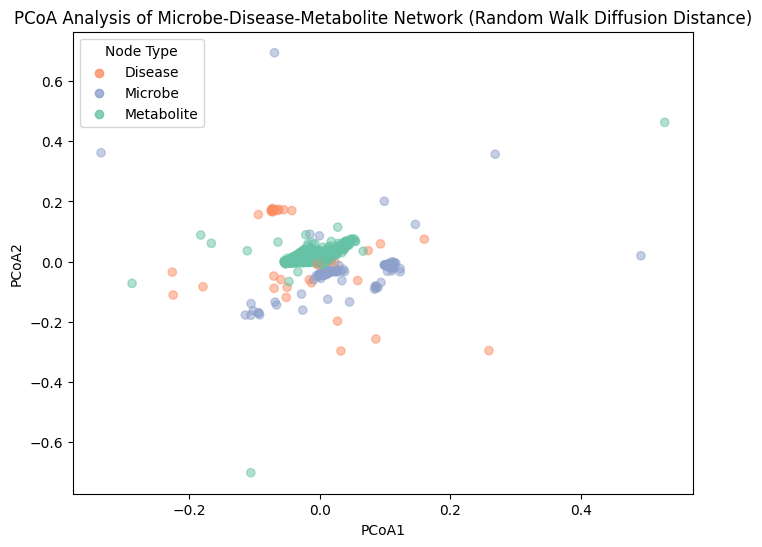

In [203]:
plt.figure(figsize=(8, 6))

palette = sns.color_palette("Set2")
disease_color, microbe_color, metabolite_color = palette[1], palette[2], palette[0]
node_colors = [
    disease_color if G.nodes[node]['type'] == 'disease' else
    microbe_color if G.nodes[node]['type'] == 'microbe' else
    metabolite_color for node in pcoa_df['node']
]

plt.scatter(pcoa_df['PCoA1'], pcoa_df['PCoA2'], c=node_colors, alpha=0.5)
plt.scatter([], [], color=disease_color, alpha=0.8, label='Disease')
plt.scatter([], [], color=microbe_color, alpha=0.8, label='Microbe')
plt.scatter([], [], color=metabolite_color, alpha=0.8, label='Metabolite')
plt.legend(title='Node Type')
plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.title("PCoA Analysis of Microbe-Disease-Metabolite Network (Random Walk Diffusion Distance)")
plt.show()

In [204]:
# compute pairwise distance for close distant nodes
microbes_df = pcoa_df[pcoa_df['type'] == 'microbe'].reset_index(drop=True)
diseases_df = pcoa_df[pcoa_df['type'] == 'disease'].reset_index(drop=True)
metabolites_df = pcoa_df[pcoa_df['type'] == 'metabolite'].reset_index(drop=True)
microbe_disease_distances = cdist(microbes_df[['PCoA1', 'PCoA2']], diseases_df[['PCoA1', 'PCoA2']], metric='euclidean')
metabolite_disease_distances = cdist(metabolites_df[['PCoA1', 'PCoA2']], diseases_df[['PCoA1', 'PCoA2']], metric='euclidean')

In [205]:
closest_microbe_disease_idx = microbe_disease_distances.argmin(axis=1)
closest_metabolite_disease_idx = metabolite_disease_distances.argmin(axis=1)
closest_microbe_disease = pd.DataFrame({
    'microbe': microbes_df['node'],
    'closest_disease': diseases_df.loc[closest_microbe_disease_idx, 'node'].values,
    'distance': microbe_disease_distances[np.arange(len(microbes_df)), closest_microbe_disease_idx]
})

closest_metabolite_disease = pd.DataFrame({
    'metabolite': metabolites_df['node'],
    'closest_disease': diseases_df.loc[closest_metabolite_disease_idx, 'node'].values,
    'distance': metabolite_disease_distances[np.arange(len(metabolites_df)), closest_metabolite_disease_idx]
})

In [211]:
print("\nClosest Microbe-Disease Relationships:")
print(closest_microbe_disease.sort_values(by='distance').head(5))

print("\nClosest Metabolite-Disease Relationships:")
print(closest_metabolite_disease.sort_values(by='distance').head(5))


Closest Microbe-Disease Relationships:
             microbe closest_disease  distance
268   NCBITaxon:4950   MONDO:0001711  0.003874
267   NCBITaxon:4932   MONDO:0008315  0.005733
258  NCBITaxon:32049   MONDO:0005081  0.006998
266    NCBITaxon:661   MONDO:0858950  0.011095
37     NCBITaxon:853   MONDO:0005081  0.016228

Closest Metabolite-Disease Relationships:
                  metabolite closest_disease      distance
402  PUBCHEM.COMPOUND:150929   MONDO:0007739  1.454610e-17
397    PUBCHEM.COMPOUND:2879   MONDO:0008315  8.438227e-04
313  PUBCHEM.COMPOUND:161166   MONDO:0007739  1.052342e-03
365    PUBCHEM.COMPOUND:6047   MONDO:0007739  2.269449e-03
356     PUBCHEM.COMPOUND:878   MONDO:0005649  2.408684e-03


In [214]:
triplets = pd.merge(closest_microbe_disease, closest_metabolite_disease, on='closest_disease', suffixes=('_microbe', '_metabolite'))
triplets

,microbe,closest_disease,distance_microbe,metabolite,distance_metabolite
0,NCBITaxon:1686,MONDO:0005649,0.029537,PUBCHEM.COMPOUND:998,0.005089
1,NCBITaxon:1686,MONDO:0005649,0.029537,PUBCHEM.COMPOUND:878,0.002409
2,NCBITaxon:287,MONDO:0005081,0.033578,PUBCHEM.COMPOUND:193872,0.031496
3,NCBITaxon:871665,MONDO:0005101,0.083082,PUBCHEM.COMPOUND:9958,0.083248
4,NCBITaxon:29523,MONDO:0005298,0.302347,PUBCHEM.COMPOUND:72,0.534353
...,...,...,...,...,...
2627,NCBITaxon:4950,MONDO:0001711,0.003874,PUBCHEM.COMPOUND:681,0.011750
2628,NCBITaxon:4950,MONDO:0001711,0.003874,PUBCHEM.COMPOUND:8314,0.005705
2629,NCBITaxon:4950,MONDO:0001711,0.003874,PUBCHEM.COMPOUND:6329,0.002502
2630,NCBITaxon:1526,MONDO:0005260,0.316237,PUBCHEM.COMPOUND:123743,0.111380


In [215]:
disease_distances = cdist(diseases_df[['PCoA1', 'PCoA2']], diseases_df[['PCoA1', 'PCoA2']], metric='euclidean')
closest_pairs = []
for i in range(len(disease_distances)):
    distances_to_others = disease_distances[i, :]
    distances_to_others[i] = np.inf
    closest_idx = np.argmin(distances_to_others)
    closest_pairs.append((diseases_df.iloc[i]['node'], diseases_df.iloc[closest_idx]['node'], distances_to_others[closest_idx]))

In [216]:
closest_disease_pairs = pd.DataFrame(closest_pairs, columns=['disease1', 'disease2', 'distance']).sort_values(by='distance')
closest_disease_pairs

,disease1,disease2,distance
26,MONDO:0024388,MONDO:0005154,0.000563
30,MONDO:0005154,MONDO:0024388,0.000563
33,MONDO:0011382,MONDO:0015183,0.000756
17,MONDO:0015183,MONDO:0011382,0.000756
32,MONDO:0005027,MONDO:0005154,0.000761
31,MONDO:0018076,MONDO:0005027,0.000966
7,MONDO:0010726,MONDO:0015183,0.001153
18,MONDO:0011565,MONDO:0018076,0.001941
4,MONDO:0009061,MONDO:0011565,0.002829
29,MONDO:0009861,MONDO:0005148,0.002906


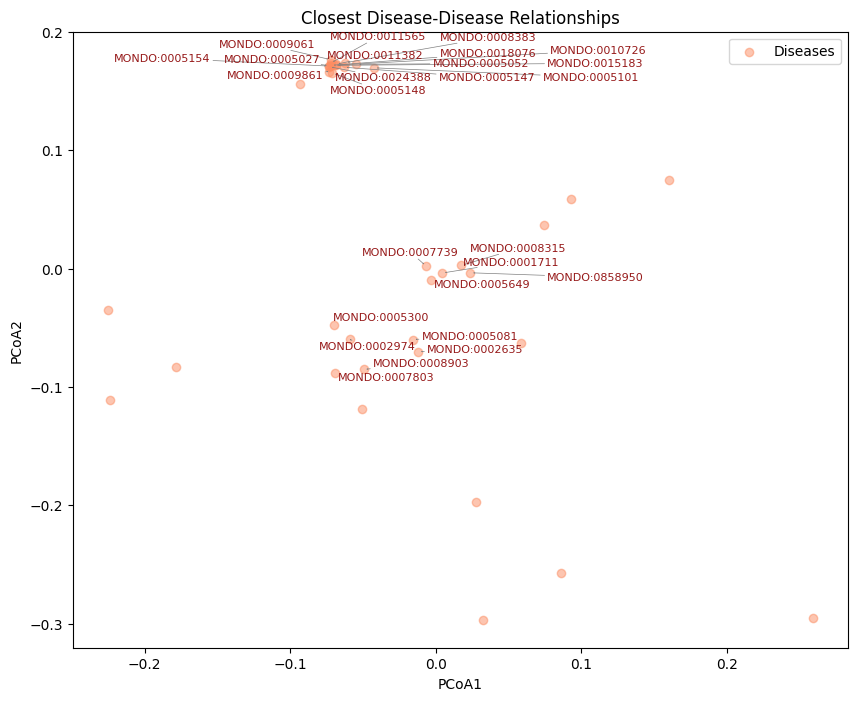

In [232]:
plt.figure(figsize=(10, 8))
plt.scatter(diseases_df['PCoA1'], diseases_df['PCoA2'], color=disease_color, label='Diseases', alpha=0.5)

top_5_nodes = set(closest_disease_pairs.head(25)[['disease1', 'disease2']].values.flatten())
texts = []
for i, row in diseases_df.iterrows():
    if row['node'] in top_5_nodes:
        texts.append(plt.text(row['PCoA1'], row['PCoA2'], row['node'], fontsize=8, alpha=0.9, color='darkred'))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.title("Closest Disease-Disease Relationships")
plt.legend()
plt.show()

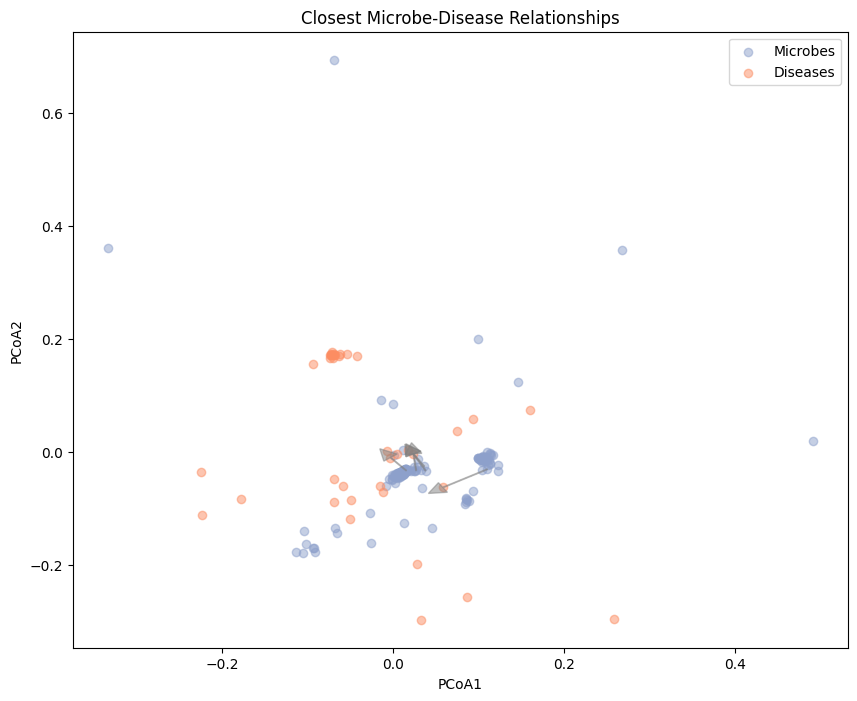

In [225]:
plt.figure(figsize=(10, 8))

plt.scatter(microbes_df['PCoA1'], microbes_df['PCoA2'], color=microbe_color, label='Microbes', alpha=0.5)
plt.scatter(diseases_df['PCoA1'], diseases_df['PCoA2'], color=disease_color, label='Diseases', alpha=0.5)

for _, row in closest_microbe_disease.head(5).iterrows():
    microbe_pos = microbes_df.loc[microbes_df['node'] == row['microbe'], ['PCoA1', 'PCoA2']].values[0]
    disease_pos = diseases_df.loc[diseases_df['node'] == row['closest_disease'], ['PCoA1', 'PCoA2']].values[0]
    plt.arrow(microbe_pos[0], microbe_pos[1], disease_pos[0] - microbe_pos[0], disease_pos[1] - microbe_pos[1],
              color='gray', alpha=0.5, head_width=0.02, head_length=0.02)

plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.legend()
plt.title("Closest Microbe-Disease Relationships")
plt.show()

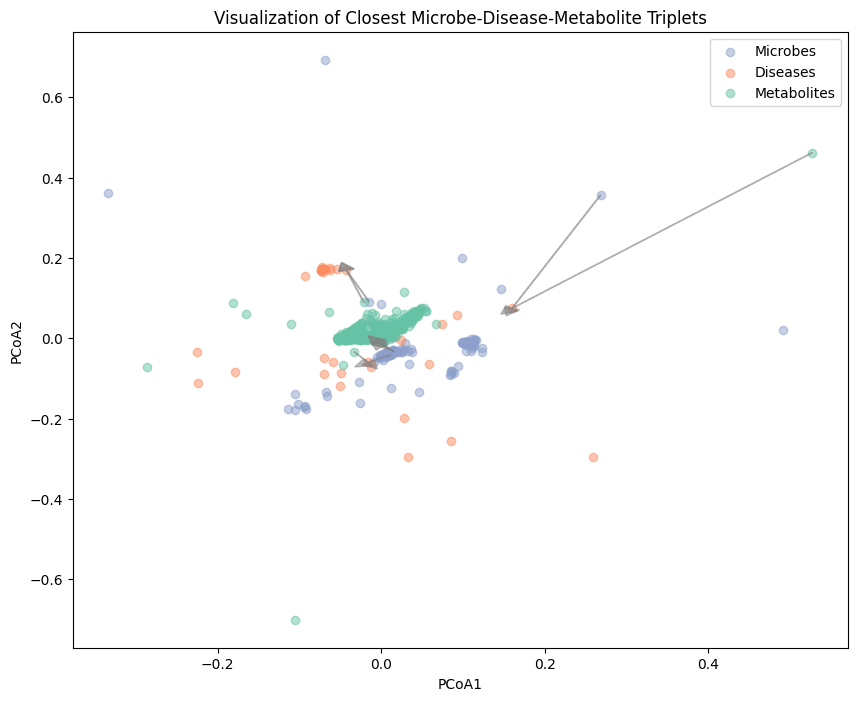

In [213]:
plt.figure(figsize=(10, 8))

plt.scatter(microbes_df['PCoA1'], microbes_df['PCoA2'], color=microbe_color, label='Microbes', alpha=0.5)
plt.scatter(diseases_df['PCoA1'], diseases_df['PCoA2'], color=disease_color, label='Diseases', alpha=0.5)
plt.scatter(metabolites_df['PCoA1'], metabolites_df['PCoA2'], color=metabolite_color, label='Metabolites', alpha=0.5)

for _, row in triplets.head(5).iterrows():
    # Microbe to Disease
    microbe_pos = microbes_df.loc[microbes_df['node'] == row['microbe'], ['PCoA1', 'PCoA2']].values[0]
    disease_pos = diseases_df.loc[diseases_df['node'] == row['closest_disease'], ['PCoA1', 'PCoA2']].values[0]
    plt.arrow(microbe_pos[0], microbe_pos[1], disease_pos[0] - microbe_pos[0], disease_pos[1] - microbe_pos[1],
              color='gray', alpha=0.5, head_width=0.02, head_length=0.02)

    # Metabolite to Disease
    metabolite_pos = metabolites_df.loc[metabolites_df['node'] == row['metabolite'], ['PCoA1', 'PCoA2']].values[0]
    plt.arrow(metabolite_pos[0], metabolite_pos[1], disease_pos[0] - metabolite_pos[0], disease_pos[1] - metabolite_pos[1],
              color='gray', alpha=0.5, head_width=0.02, head_length=0.02)

plt.xlabel("PCoA1")
plt.ylabel("PCoA2")
plt.title("Visualization of Closest Microbe-Disease-Metabolite Triplets")
plt.legend()
plt.show()

### neighbor analysis

In [17]:
neighbor_counts = {node: len(list(G.neighbors(node))) for node in G.nodes()}

In [18]:
counts = list(neighbor_counts.values())
counts_array = np.array(counts)

# Compute statistical summary
summary = {
    "count": len(counts_array),
    "mean": np.mean(counts_array),
    "std": np.std(counts_array),
    "min": np.min(counts_array),
    "25%": np.percentile(counts_array, 25),
    "50% (median)": np.median(counts_array),
    "75%": np.percentile(counts_array, 75),
    "max": np.max(counts_array),
}
summary

{'count': 773,
 'mean': np.float64(42.06985769728331),
 'std': np.float64(61.35830159184571),
 'min': np.int64(1),
 '25%': np.float64(8.0),
 '50% (median)': np.float64(18.0),
 '75%': np.float64(53.0),
 'max': np.int64(389)}

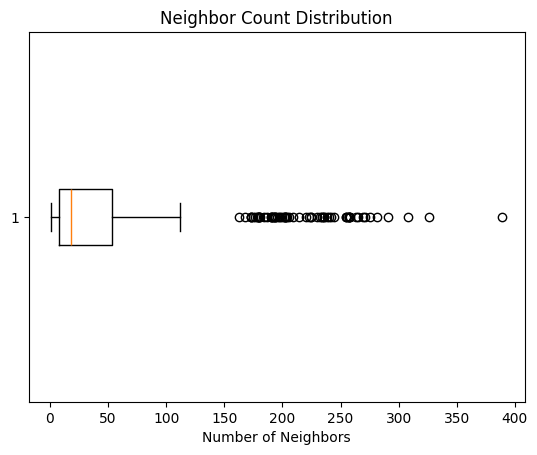

In [19]:
# box plot of neighbor counts
plt.boxplot(counts, vert=False)
plt.xlabel("Number of Neighbors")
plt.title("Neighbor Count Distribution")
plt.show()

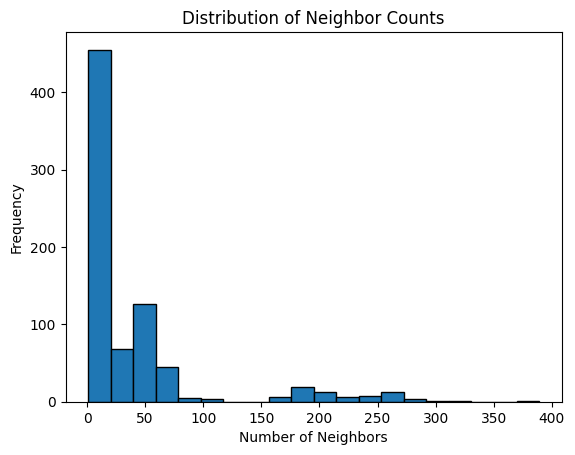

In [20]:
# histogram of neighbor counts
plt.hist(counts, bins=20, edgecolor="black")
plt.xlabel("Number of Neighbors")
plt.ylabel("Frequency")
plt.title("Distribution of Neighbor Counts")
plt.show()

In [21]:
filtered_counts = {k: v for k, v in neighbor_counts.items() if v > 10}
print(f"Number of nodes with more than 10 neighbors: {len(filtered_counts)}")

Number of nodes with more than 10 neighbors: 556


### Summary of filtered MKG datasets with common nodes
- The filtered MKG datasets consist of three relational datasets: Microbe-Disease (MD), Microbe-Metabolite (MMET), and Metabolite-Disease (HMDB_METD).
- The MD dataset has 4,187 unique edges, the MMET dataset has 11,170 unique edges, and the HMDB_METD dataset has 903 unique edges. Total edges are 16,260.
- Total node count is 773 with 272 unique microbes, 39 unique diseases, and 462 unique metabolites.
- Common Microbes in filtered M-D: 90.11%; Common Microbes in filtered M-MET: 96.34%; Common Diseases in filtered M-D: 85.71%; Common Diseases in filtered HMDB_MET-D: 88.24%; Common Metabolites in filtered M-MET: 78.45%; Common Metabolites in filtered HMDB_MET-D: 86.86%.
- The relational datasets from filtered MKG has 1 connected large component.
- Average neighbor count is 42, median neighbor count is 18.

***

### create index mappings for common MKG

In [22]:
# assign indices to each unique node type and export data
microbes = set(filtered_md['microbe']) | set(filtered_mmet['microbe'])
diseases = set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])
metabolites = set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])

# create index mappings
microbe_index = {microbe: idx for idx, microbe in enumerate(sorted(microbes))}
disease_index = {disease: idx for idx, disease in enumerate(sorted(diseases))}
metabolite_index = {metabolite: idx for idx, metabolite in enumerate(sorted(metabolites))}

# replace nodes in filtered datasets with their indices
filtered_md_indexed = filtered_md.copy()
filtered_md_indexed['microbe'] = filtered_md_indexed['microbe'].map(microbe_index)
filtered_md_indexed['disease'] = filtered_md_indexed['disease'].map(disease_index)

filtered_mmet_indexed = filtered_mmet.copy()
filtered_mmet_indexed['microbe'] = filtered_mmet_indexed['microbe'].map(microbe_index)
filtered_mmet_indexed['metabolite'] = filtered_mmet_indexed['metabolite'].map(metabolite_index)

filtered_hmdb_metd_indexed = filtered_hmdb_metd.copy()
filtered_hmdb_metd_indexed['metabolite'] = filtered_hmdb_metd_indexed['metabolite'].map(metabolite_index)
filtered_hmdb_metd_indexed['disease'] = filtered_hmdb_metd_indexed['disease'].map(disease_index)

In [23]:
print(f"Unique edges in filtered_md_indexed: {len(filtered_md_indexed[['microbe', 'disease']].drop_duplicates())}")
print(f"Unique edges in filtered_mmet_indexed: {len(filtered_mmet_indexed[['microbe', 'metabolite']].drop_duplicates())}")
print(f"Unique edges in filtered_hmdb_metd_indexed: {len(filtered_hmdb_metd_indexed[['metabolite', 'disease']].drop_duplicates())}")

Unique edges in filtered_md_indexed: 4187
Unique edges in filtered_mmet_indexed: 11170
Unique edges in filtered_hmdb_metd_indexed: 903


In [78]:
# save indexed datasets for common nodes
filtered_md_indexed.to_csv("MKG/common_microbe_disease_idx.dat", sep="\t", index=False, header=False)
filtered_mmet_indexed.to_csv("MKG/common_microbe_metabolite_idx.dat", sep="\t", index=False, header=False)
filtered_hmdb_metd_indexed.to_csv("MKG/common_metabolite_disease_idx.dat", sep="\t", index=False, header=False)

# export unique nodes with their indices
pd.DataFrame(microbe_index.items(), columns=["microbe", "index"]).to_csv("MKG/unique_microbes_idx.dat", sep="\t", index=False, header=False)
pd.DataFrame(disease_index.items(), columns=["disease", "index"]).to_csv("MKG/unique_diseases_idx.dat", sep="\t", index=False, header=False)
pd.DataFrame(metabolite_index.items(), columns=["metabolite", "index"]).to_csv("MKG/unique_metabolites_idx.dat", sep="\t", index=False, header=False)

***

### adjacency matrix

In [24]:
# create adjacency matrix
num_microbe = 272
num_disease = 39
num_metabolite = 462

dim = num_microbe + num_disease + num_metabolite

type_mask = np.zeros(dim, dtype=np.int16)
type_mask[num_microbe : num_microbe + num_disease] = 1
type_mask[num_microbe + num_disease :] = 2

adjM = np.zeros((dim, dim), dtype=np.int16)
for _, row in filtered_md_indexed.iterrows():
    microID = row["microbe"]
    diseaseID = num_microbe + row["disease"]
    adjM[microID, diseaseID] = 1
    adjM[diseaseID, microID] = 1
for _, row in filtered_mmet_indexed.iterrows():
    microID = row["microbe"]
    metID = num_microbe + num_disease + row["metabolite"]
    adjM[microID, metID] = 1
    adjM[metID, microID] = 1
for _, row in filtered_hmdb_metd_indexed.iterrows():
    metID = num_microbe + num_disease + row["metabolite"]
    diseaseID = num_microbe + row["disease"]
    adjM[metID, diseaseID] = 1
    adjM[diseaseID, metID] = 1

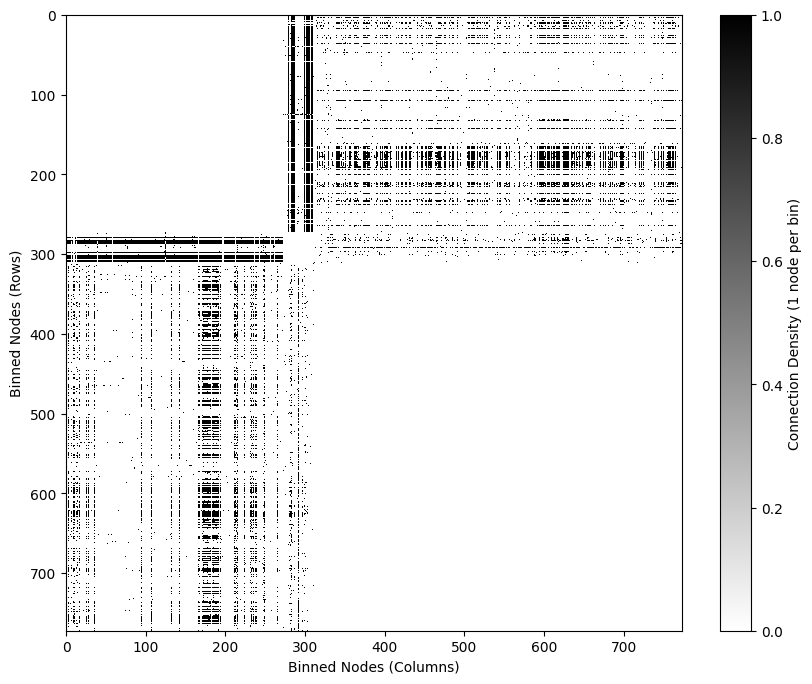

In [26]:
# function to downsample a large matrix
def downsample_matrix(matrix, bin_size):
    m, n = matrix.shape
    m_bins, n_bins = m // bin_size, n // bin_size
    # reshape into bins and sum within each bin
    downsampled = matrix[:m_bins * bin_size, :n_bins * bin_size].reshape(
        m_bins, bin_size, n_bins, bin_size
    ).sum(axis=(1, 3))
    return downsampled

# parameters for downsampling
bin_size = 1
downsampled_adjM = downsample_matrix(adjM, bin_size)

plt.figure(figsize=(10, 8))
plt.imshow(downsampled_adjM, cmap="binary", interpolation="nearest")
plt.colorbar(label="Connection Density (1 node per bin)")
plt.xlabel("Binned Nodes (Columns)")
plt.ylabel("Binned Nodes (Rows)")
plt.show()

In [32]:
from scipy.sparse import coo_matrix
def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='white', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    return ax

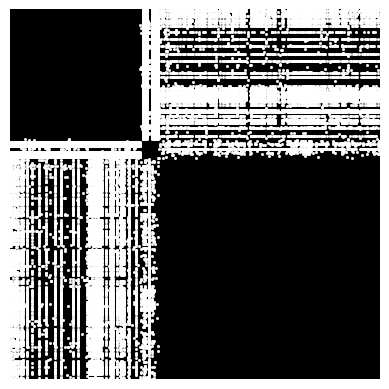

<Axes: >

In [33]:
plot_coo_matrix(adjM)

***

In [79]:
# create files for cosmograph visualization
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])

# add metabolites with a color
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors.csv", index=False)

# edge file
edges = []

# add microbe-disease edges
edges.extend(filtered_md[["microbe", "disease", "weight"]].values.tolist())

# add microbe-metabolite edges
edges.extend(filtered_mmet[["microbe", "metabolite", "weight"]].values.tolist())

# add metabolite-disease edges
edges.extend(filtered_hmdb_metd[["metabolite", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels.csv", index=False)

773
16260


In [80]:
# create files for cosmograph visualization (remove metabolites)
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])


nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_met.csv", index=False)

# edge file
edges = []

# add microbe-disease edges
edges.extend(filtered_md[["microbe", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_met.csv", index=False)

311
4187


In [81]:
# create files for cosmograph visualization (remove microbes)
# node file
nodes = []

# add diseases with a color
for disease in sorted(set(filtered_md['disease']) | set(filtered_hmdb_metd['disease'])):
    nodes.append([disease, "disease", "red"])

# add metabolites with a color
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
print(len(nodes_df.drop_duplicates()))
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_micro.csv", index=False)

# edge file
edges = []

# add metabolite-disease edges
edges.extend(filtered_hmdb_metd[["metabolite", "disease", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
print(len(edges_df.drop_duplicates()))
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_micro.csv", index=False)

501
903


In [210]:
# create files for cosmograph visualization (remove diseases)
# node file
nodes = []

# add microbes with a color
for microbe in sorted(set(filtered_md['microbe']) | set(filtered_mmet['microbe'])):
    nodes.append([microbe, "microbe", "blue"])
for metabolite in sorted(set(filtered_mmet['metabolite']) | set(filtered_hmdb_metd['metabolite'])):
    nodes.append([metabolite, "metabolite", "green"])

nodes_df = pd.DataFrame(nodes, columns=["id", "type", "node_color"])
nodes_df.to_csv("MKG_cosmograph_nodes_with_colors_no_dis.csv", index=False)

# edge file
edges = []

# add microbe-metabolite edges
edges.extend(filtered_mmet[["microbe", "metabolite", "weight"]].values.tolist())

edges_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
edges_df.to_csv("MKG_cosmograph_edges_with_labels_no_dis.csv", index=False)